In [1]:
import pandas as pd
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator
import torch 
from visual import find_opt_thres, get_metric_invariant, load_results
from matplotlib import pyplot as plt
import pandas as pd
from visual import (find_opt_thres, 
                    get_metric_invariant, 
                    load_results, 
                    plot_pos_neg_histogram, 
                    tensor_to_csr_matrix, 
                    eval_mix_heuristic,
                    save_error_examples)
from core.data_utils.load import load_data_lp
from core.graphgps.utility.utils import init_cfg_test
# evaluator = Evaluator(name='ogbl-collab')
evaluator_hit = Evaluator(name='ogbl-collab')
evaluator_mrr = Evaluator(name='ogbl-citation2')

/home/hk-project-test-p0021478/cc7738/anaconda3/envs/TAG-LP/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   edge_index0  edge_index1      pred   gr
0         3307         7681  1.000000  1.0
1         7660         9429  0.998993  1.0
2         2121         3779  0.999982  1.0
3         1054         9517  0.704470  1.0
4         6553         7681  1.000000  1.0


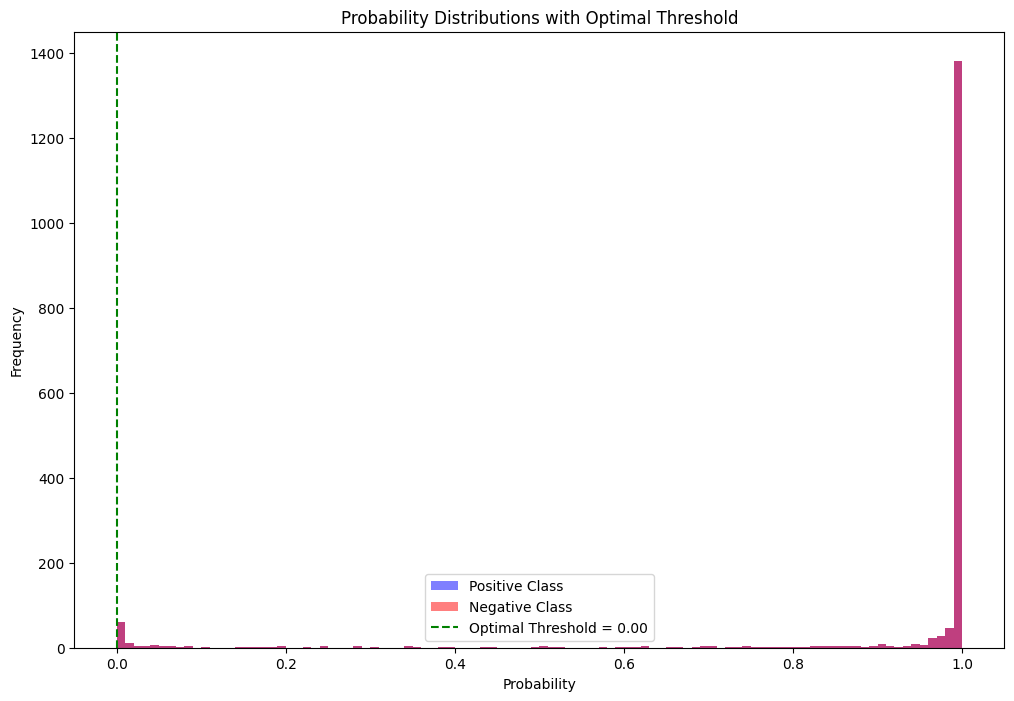

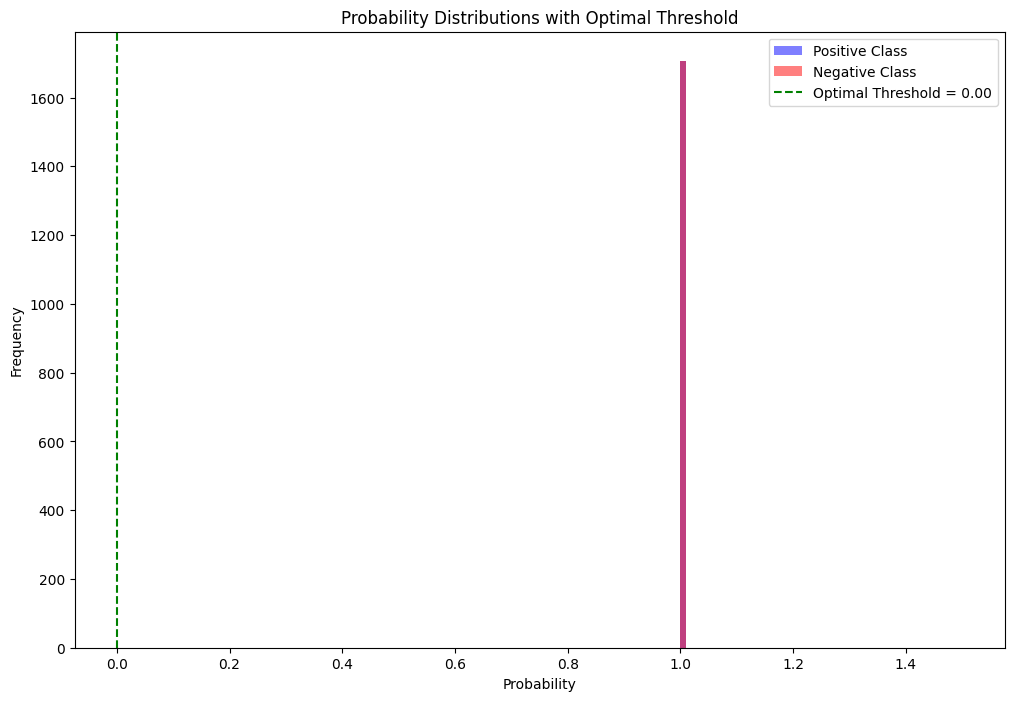

In [10]:
# Example usage
FILE_PATH = '/hkfs/work/workspace/scratch/cc7738-benchmark_tag/educational_demo/'
file_path = FILE_PATH + 'Error_analysis_ncnc_llama-2/llama-arxiv_2023-origin_dot_AUC_0.9781_MRR_0.2719.csv'

P1, P2, pos_index, neg_index = load_results(file_path)
best_thres, best_acc, pos_pred, neg_pred = find_opt_thres(P1, P2)

plot_pos_neg_histogram(P1, P2, best_thres)
plot_pos_neg_histogram(pos_pred, neg_pred, best_thres)

In [4]:
cfg = init_cfg_test()
cfg.data.name = 'arxiv_2023'
splits, text, data = load_data_lp[cfg.data.name](cfg.data)
# type 2 predict no when yes 
type_2 = neg_index[neg_pred == 1]
print(f'{len(type_2)} type 2 errors are detected.')

# type 1 predict yes when no
type_1 = neg_index[neg_pred == 1]
print(f'{len(type_1)} type 1 errors are detected.')

not loaded 0 papers.
create graph: 0.12395715713500977
[2485]
original num of nodes: 2485
num of nodes after lcc: 2485
num of edges after lcc: 10138
num of texts in dataset: 2485
1706 type 2 errors are detected.
1706 type 1 errors are detected.


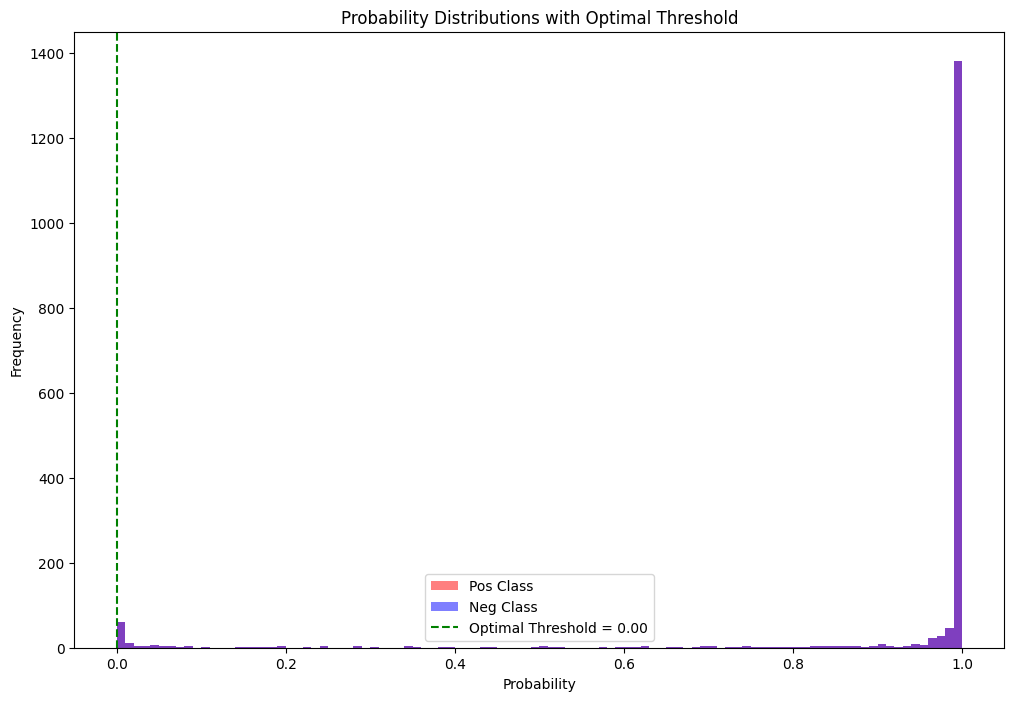

best_accuracy: 0.5, best_threshold: 0.0


In [5]:
plt.figure(figsize=(12, 8))

# Plot distributions of probabilities
plt.hist(P1, bins=100, alpha=0.5, color='red', label='Pos Class')
plt.hist(P2, bins=100, alpha=0.5, color='blue', label='Neg Class')

best_threshold, best_accuracy, pos_pred, neg_pred = find_opt_thres(P1, P2)

plt.axvline(best_threshold, color='green', linestyle='--', label=f'Optimal Threshold = {best_threshold:.2f}')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.title('Probability Distributions with Optimal Threshold')
plt.show()
print(f'best_accuracy: {best_accuracy}, best_threshold: {best_threshold}')

20it [00:00, 20.98it/s]


<Figure size 640x480 with 0 Axes>

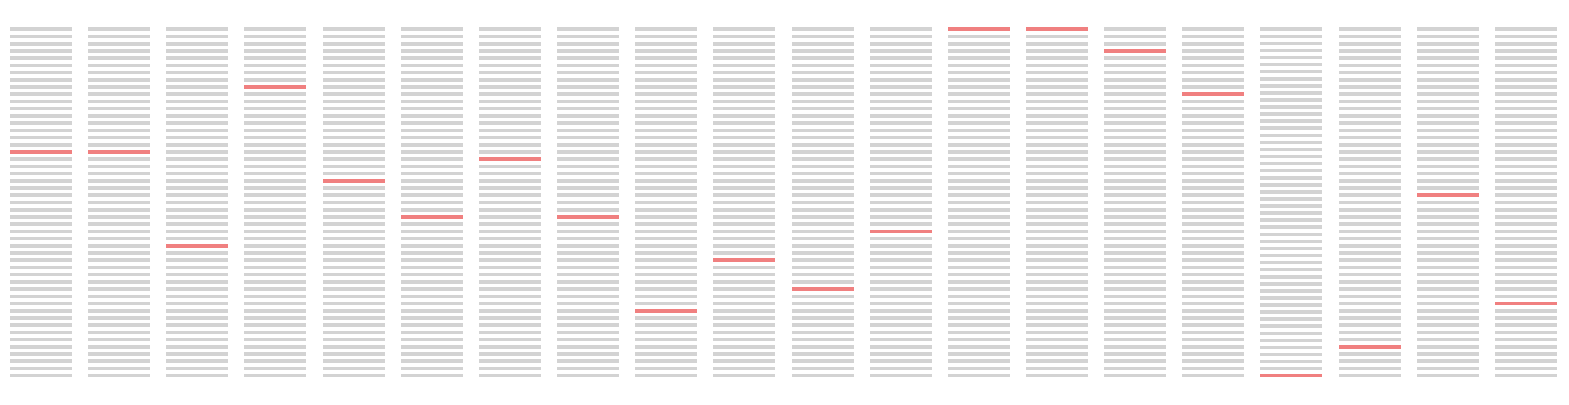

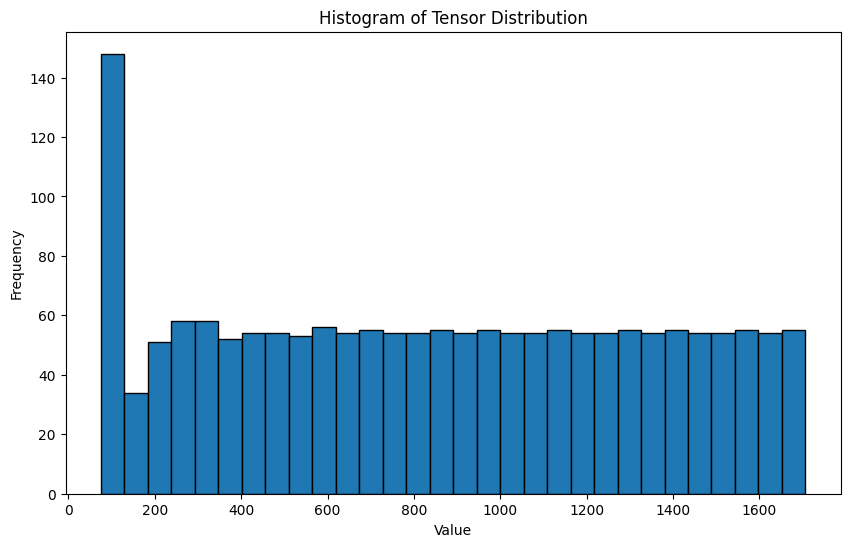

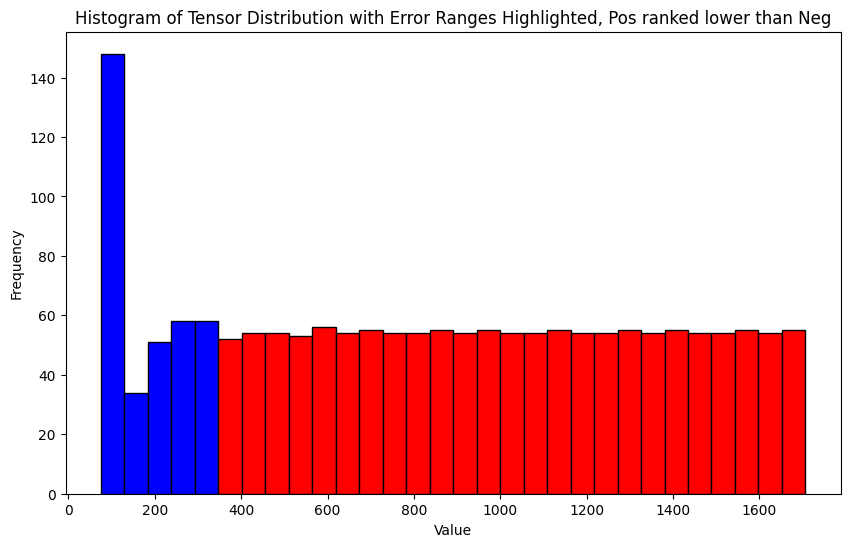

20it [00:00, 34.74it/s]


<Figure size 640x480 with 0 Axes>

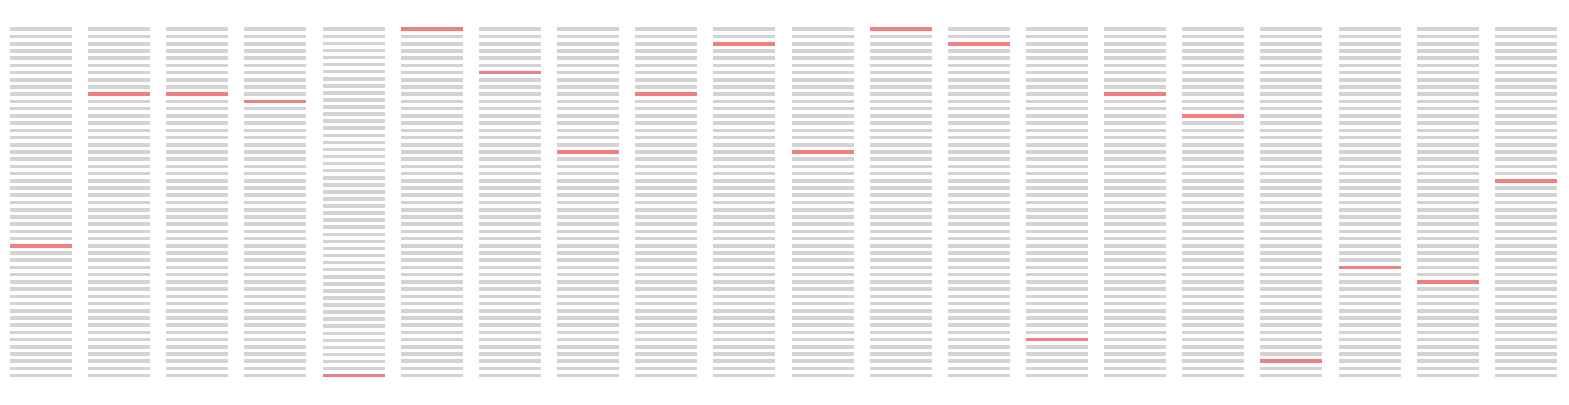

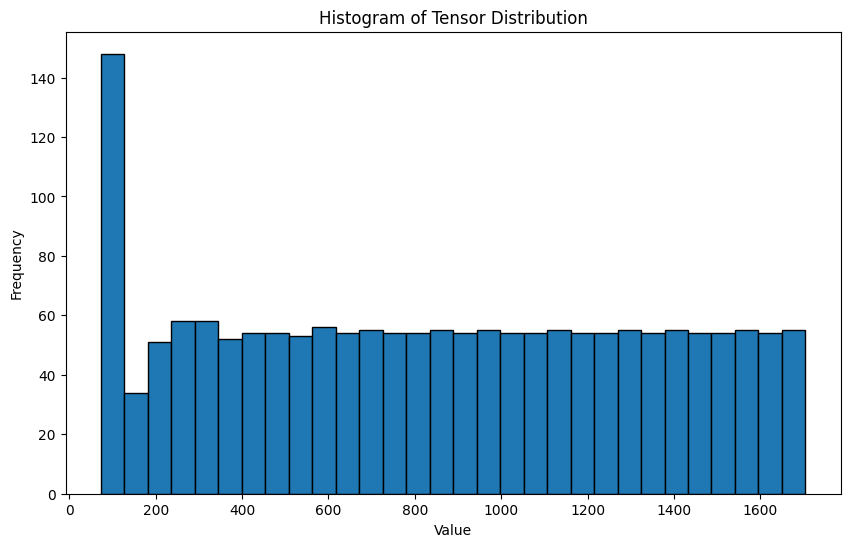

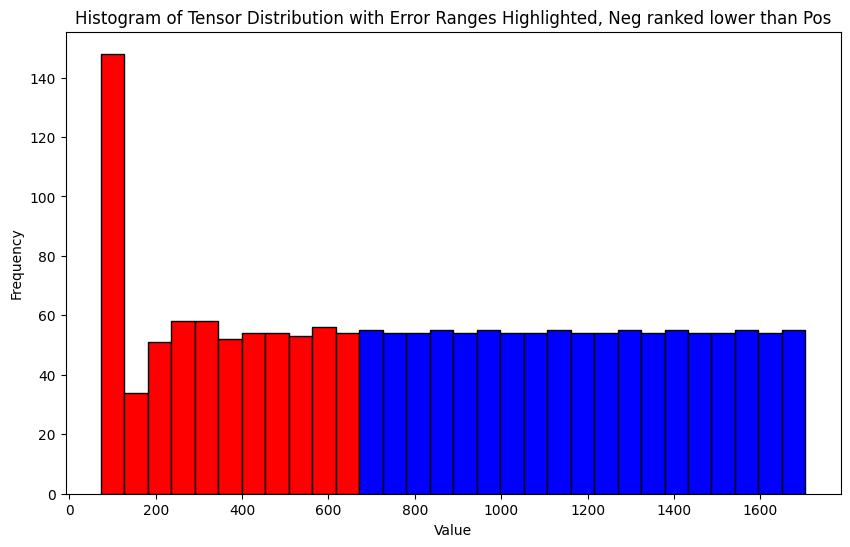

{'mrr_hit0.1': tensor(0.1067), 'mrr_hit0.2': tensor(0.2005), 'mrr_hit0.3': tensor(0.2989), 'mrr_hit0.5': tensor(0.4994), 'mrr_hit1.0': tensor(0.9994)}
{'AUC': 0.5, 'AP': 0.5}
{'mrr_hit0.1': tensor(0.1067), 'mrr_hit0.2': tensor(0.2005), 'mrr_hit0.3': tensor(0.3001), 'mrr_hit0.5': tensor(0.5006), 'mrr_hit1.0': tensor(1.)}


In [6]:
k_list  = [0.1, 0.2, 0.3, 0.5, 1]
pos_index = torch.tensor(pos_index)
neg_index = torch.tensor(neg_index)
P1 = torch.tensor(P1)
P2 = torch.tensor(P2)
mrr_pos2neg, mrr_neg2pos, result_auc_test, pos_edge_index_err, pos_rank_err, neg_edge_index_err, neg_rank_err = get_metric_invariant(P1, pos_index, P2, neg_index, k_list)

print(mrr_pos2neg)
print(result_auc_test)
print(mrr_neg2pos)


In [7]:
import os
import sys

# Assuming your target directory is one level up from the current working directory
notebook_dir = os.getcwd()  
target_dir = os.path.abspath(os.path.join(notebook_dir, '..'))

sys.path.insert(0, target_dir)
from core.data_utils.load import load_data_lp
from core.graphgps.utility.utils import init_cfg_test

cfg = init_cfg_test()

In [8]:
splits, text, data = load_data_lp[cfg.data.name](cfg.data)

not loaded 0 papers.
create graph: 0.07459235191345215
[2485]
original num of nodes: 2485
num of nodes after lcc: 2485
num of edges after lcc: 10138
num of texts in dataset: 2485


In [9]:
type_2 = pos_index[pos_pred == 0]
print(f'{len(type_2)} type 2 errors are detected.')

# type 1 predict yes when no
type_1 = neg_index[neg_pred == 1]
print(f'{len(type_1)} type 1 errors are detected.')


df = save_error_examples(type_2, text)
print(df.head)
df.to_csv('type_2_llama_cora.csv', index=False)

df = save_error_examples(type_1, text)
print(df.head)
df.to_csv('type_1_llama_cora.csv', index=False)

0 type 2 errors are detected.
1706 type 1 errors are detected.
<bound method NDFrame.head of Empty DataFrame
Columns: []
Index: []>


IndexError: list index out of range

## What Pos is predicted as Neg? Type II.

In [29]:
for row in pos_edge_index_err:
    print(f'source: {text[row[0]]}, \n target: {text[row[1]]}')

source: Title: Mathematical Programming in Neural Networks  
Abstract: This paper highlights the role of mathematical programming, particularly linear programming, in training neural networks. A neural network description is given in terms of separating planes in the input space that suggests the use of linear programming for determining these planes. A more standard description in terms of a mean square error in the output space is also given, which leads to the use of unconstrained minimization techniques for training a neural network. The linear programming approach is demonstrated by a brief description of a system for breast cancer diagnosis that has been in use for the last four years at a major medical facility., 
 target: Title: CANCER DIAGNOSIS AND PROGNOSIS VIA LINEAR-PROGRAMMING-BASED MACHINE LEARNING  
Abstract: In this paper I give a review of ensemble learning using a simple example. 
source: Title: Learning networks for face analysis and synthesis  
Abstract: This paper 

In [30]:
from IPython.display import display, Markdown

for row in pos_edge_index_err:
    src = text[row[0]]
    tgt = text[row[1]]
    display(Markdown(f"**Source:** {src}  \n**Target:** {tgt}"))

**Source:** Title: Mathematical Programming in Neural Networks  
Abstract: This paper highlights the role of mathematical programming, particularly linear programming, in training neural networks. A neural network description is given in terms of separating planes in the input space that suggests the use of linear programming for determining these planes. A more standard description in terms of a mean square error in the output space is also given, which leads to the use of unconstrained minimization techniques for training a neural network. The linear programming approach is demonstrated by a brief description of a system for breast cancer diagnosis that has been in use for the last four years at a major medical facility.  
**Target:** Title: CANCER DIAGNOSIS AND PROGNOSIS VIA LINEAR-PROGRAMMING-BASED MACHINE LEARNING  
Abstract: In this paper I give a review of ensemble learning using a simple example. 

**Source:** Title: Learning networks for face analysis and synthesis  
Abstract: This paper presents an overview of the face-related projects in our group. The unifying theme underlying our work is the use of example-based learning methods for both analyzing and synthesizing face images. We label the example face images (and for the problem of face detection, "near miss" faces as well) with descriptive parameters for pose, expression, identity, and face vs. non-face. Then, by using example-based learning techniques, we develop networks for performing analysis tasks such as pose and expression estimation, face recognition, and face detection in cluttered scenes. In addition to these analysis applications, we show how the example-based technique can also be used as a novel method for image synthesis that is for computer graphics.   
**Target:** Title: Modeling Volatility using State Space Models  
Abstract: In time series problems, noise can be divided into two categories: dynamic noise which drives the process, and observational noise which is added in the measurement process, but does not influence future values of the system. In this framework, empirical volatilities (the squared relative returns of prices) exhibit a significant amount of observational noise. To model and predict their time evolution adequately, we estimate state space models that explicitly include observational noise. We obtain relaxation times for shocks in the logarithm of volatility ranging from three weeks (for foreign exchange) to three to five months (for stock indices). In most cases, a two-dimensional hidden state is required to yield residuals that are consistent with white noise. We compare these results with ordinary autoregressive models (without a hidden state) and find that autoregressive models underestimate the relaxation times by about two orders of magnitude due to their ignoring the distinction between observational and dynamic noise. This new interpretation of the dynamics of volatility in terms of relaxators in a state space model carries over to stochastic volatility models and to GARCH models, and is useful for several problems in finance, including risk management and the pricing of derivative securities. 

**Source:** Title: LEARNING COMPLEX, EXTENDED SEQUENCES USING THE PRINCIPLE OF HISTORY COMPRESSION (Neural Computation, 4(2):234-242, 1992)  
Abstract: Previous neural network learning algorithms for sequence processing are computationally expensive and perform poorly when it comes to long time lags. This paper first introduces a simple principle for reducing the descriptions of event sequences without loss of information. A consequence of this principle is that only unexpected inputs can be relevant. This insight leads to the construction of neural architectures that learn to `divide and conquer' by recursively decomposing sequences. I describe two architectures. The first functions as a self-organizing multi-level hierarchy of recurrent networks. The second, involving only two recurrent networks, tries to collapse a multi-level predictor hierarchy into a single recurrent net. Experiments show that the system can require less computation per time step and many fewer training sequences than conventional training algorithms for recurrent nets.  
**Target:** Title: GUESSING CAN OUTPERFORM MANY LONG TIME LAG ALGORITHMS  
Abstract: Numerous recent papers focus on standard recurrent nets' problems with long time lags between relevant signals. Some propose rather sophisticated, alternative methods. We show: many problems used to test previous methods can be solved more quickly by random weight guessing. 

**Source:** Title: Using Mixtures of Factor Analyzers for Segmentation and Pose Estimation  Category: Visual Processing Preference: Oral  
Abstract: To read a hand-written digit string, it is helpful to segment the image into separate digits. Bottom-up segmentation heuristics often fail when neighboring digits overlap substantially. We describe a system that has a stochastic generative model of each digit class and we show that this is the only knowledge required for segmentation. The system uses Gibbs sampling to construct a perceptual interpretation of a digit string and segmentation arises naturally from the "explaining away" effects that occur during Bayesian inference. By using conditional mixtures of factor analyzers, it is possible to extract an explicit, compact representation of the instantiation parameters that describe the pose of each digit. These instantiation parameters can then be used as the inputs to a higher level system that models the relationships between digits. The same technique could be used to model individual digits as redundancies between the instantiation parameters of their parts.  
**Target:** Title: Using generative models for handwritten digit recognition  
Abstract: Genetic Programming is a method of program discovery consisting of a special kind of genetic algorithm capable of operating on nonlinear chromosomes (parse trees) representing programs and an interpreter which can run the programs being optimised. This paper describes PDGP (Parallel Distributed Genetic Programming), a new form of genetic programming which is suitable for the development of fine-grained parallel programs. PDGP is based on a graph-like representation for parallel programs which is manipulated by crossover and mutation operators which guarantee the syntactic correctness of the offspring. The paper describes these operators and reports some preliminary results obtained with this paradigm. 

**Source:** Title: On Convergence Properties of the EM Algorithm for Gaussian Mixtures  
Abstract: We build up the mathematical connection between the "Expectation-Maximization" (EM) algorithm and gradient-based approaches for maximum likelihood learning of finite Gaussian mixtures. We show that the EM step in parameter space is obtained from the gradient via a projection matrix P , and we provide an explicit expression for the matrix. We then analyze the convergence of EM in terms of special properties of P and provide new results analyzing the effect that P has on the likelihood surface. Based on these mathematical results, we present a comparative discussion of the advantages and disadvantages of EM and other algorithms for the learning of Gaussian mixture models. This report describes research done at the Center for Biological and Computational Learning and the Artificial Intelligence Laboratory of the Massachusetts Institute of Technology. Support for the Center is provided in part by a grant from the National Science Foundation under contract ASC-9217041. Support for the laboratory's artificial intelligence research is provided in part by the Advanced Research Projects Agency of the Department of Defense under Office of Naval Research contract N00000-00-A-0000. The authors were also supported by the HK RGC Earmarked Grant CUHK250/94E, by a grant from the McDonnell-Pew Foundation, by a grant from ATR Human Information Processing Research Laboratories, by a grant from Siemens Corporation, and by grant N00014-90-1-0777 from the Office of Naval Research. Michael I. Jordan is an NSF Presidential Young Investigator.   
**Target:** Title: CLASSIFICATION USING HIERARCHICAL MIXTURES OF EXPERTS  
Abstract: There has recently been widespread interest in the use of multiple models for classification and regression in the statistics and neural networks communities. The Hierarchical Mixture of Experts (HME) [1] has been successful in a number of regression problems, yielding significantly faster training through the use of the Expectation Maximisation algorithm. In this paper we extend the HME to classification and results are reported for three common classification benchmark tests: Exclusive-Or, N-input Parity and Two Spirals. 

**Source:** Title: Concept Learning and Heuristic Classification in Weak-Theory Domains 1  
Abstract: We use a simple and illustrative example to expose some of the main ideas of Evidential Probability. Specifically, we show how the use of an acceptance rule naturally leads to the use of intervals to represent probabilities, how change of opinion due to experience can be facilitated, and how probabilities concerning compound experiments or events can be computed given the proper knowledge of the underlying distributions.  
**Target:** Title: Learning to coordinate without sharing information  
Abstract: Researchers in the field of Distributed Artificial Intelligence (DAI) have been developing efficient mechanisms to coordinate the activities of multiple autonomous agents. The need for coordination arises because agents have to share resources and expertise required to achieve their goals. Previous work in the area includes using sophisticated information exchange protocols, investigating heuristics for negotiation, and developing formal models of possibilities of conflict and cooperation among agent interests. In order to handle the changing requirements of continuous and dynamic environments, we propose learning as a means to provide additional possibilities for effective coordination. We use reinforcement learning techniques on a block pushing problem to show that agents can learn complimentary policies to follow a desired path without any knowledge about each other. We theoretically analyze and experimentally verify the effects of learning rate on system convergence, and demonstrate benefits of using learned coordination knowledge on similar problems. Reinforcement learning based coordination can be achieved in both cooperative and non-cooperative domains, and in domains with noisy communication channels and other stochastic characteristics that present a formidable challenge to using other coordination schemes. 

**Source:** Title: Improving the Performance of Evolutionary Optimization by Dynamically Scaling the Evaluation Function  
Abstract: Traditional evolutionary optimization algorithms assume a static evaluation function, according to which solutions are evolved. Incremental evolution is an approach through which a dynamic evaluation function is scaled over time in order to improve the performance of evolutionary optimization. In this paper, we present empirical results that demonstrate the effectiveness of this approach for genetic programming. Using two domains, a two-agent pursuit-evasion game and the Tracker [6] trail-following task, we demonstrate that incremental evolution is most successful when applied near the beginning of an evolutionary run. We also show that incremental evolution can be successful when the intermediate evaluation functions are more difficult than the target evaluation function, as well as when they are easier than the target function.   
**Target:** Title: Adaptation in constant utility non-stationary environments  
Abstract: Environments that vary over time present a fundamental problem to adaptive systems. Although in the worst case there is no hope of effective adaptation, some forms environmental variability do provide adaptive opportunities. We consider a broad class of non-stationary environments, those which combine a variable result function with an invariant utility function, and demonstrate via simulation that an adaptive strategy employing both evolution and learning can tolerate a much higher rate of environmental variation than an evolution-only strategy. We suggest that in many cases where stability has previously been assumed, the constant utility non-stationary environment may in fact be a more powerful viewpoint.

**Source:** Title: An Incremental Interactive Algorithm for Regular Grammar Inference  
Abstract: We present provably correct interactive algorithms for learning regular grammars from positive examples and membership queries. A structurally complete set of strings from a language L(G) corresponding to a target regular grammar G implicitly specifies a lattice of finite state automata (FSA) which contains a FSA M G corresponding to G. The lattice is compactly represented as a version-space and M G is identified by searching the version-space using membership queries. We explore the problem of regular grammar inference in a setting where positive examples are provided intermittently. We provide an incremental version of the algorithm along with a set of sufficient conditions for its convergence.  
**Target:** Title: Toward Learning Systems That Integrate Different Strategies and Representations TR93-22  
Abstract: Temporal difference (TD) methods constitute a class of methods for learning predictions in multi-step prediction problems, parameterized by a recency factor . Currently the most important application of these methods is to temporal credit assignment in reinforcement learning. Well known reinforcement learning algorithms, such as AHC or Q-learning, may be viewed as instances of TD learning. This paper examines the issues of the efficient and general implementation of TD() for arbitrary , for use with reinforcement learning algorithms optimizing the discounted sum of rewards. The traditional approach, based on eligibility traces, is argued to suffer from both inefficiency and lack of generality. The TTD (Truncated Temporal Differences) procedure is proposed as an alternative, that indeed only approximates TD(), but requires very little computation per action and can be used with arbitrary function representation methods. The idea from which it is derived is fairly simple and not new, but probably unexplored so far. Encouraging experimental results are presented, suggesting that using &gt; 0 with the TTD procedure allows one to obtain a significant learning speedup at essentially the same cost as usual TD(0) learning.

**Source:** Title: A hierarchical ensemble of decision trees applied to classifying data from a psychological experiment  
Abstract: Classifying by hand complex data coming from psychology experiments can be a long and difficult task, because of the quantity of data to classify and the amount of training it may require. One way to alleviate this problem is to use machine learning techniques. We built a classifier based on decision trees that reproduces the classifying process used by two humans on a sample of data and that learns how to classify unseen data. The automatic classifier proved to be more accurate, more constant and much faster than classification by hand.   
**Target:** Title: Machine Learning Research: Four Current Directions  
Abstract: Machine Learning research has been making great progress is many directions. This article summarizes four of these directions and discusses some current open problems. The four directions are (a) improving classification accuracy by learning ensembles of classifiers, (b) methods for scaling up supervised learning algorithms, (c) reinforcement learning, and (d) learning complex stochastic models. 

**Source:** Title: Using Path Diagrams as a Structural Equation Modelling Tool  
Abstract: Reinforcement learning is the problem of generating optimal behavior in a sequential decision-making environment given the opportunity of interacting with it. Many algorithms for solving reinforcement-learning problems work by computing improved estimates of the optimal value function. We extend prior analyses of reinforcement-learning algorithms and present a powerful new theorem that can provide a unified analysis of value-function-based reinforcement-learning algorithms. The usefulness of the theorem lies in how it allows the asynchronous convergence of a complex reinforcement-learning algorithm to be proven by verifying that a simpler synchronous algorithm converges. We illustrate the application of the theorem by analyzing the convergence of Q-learning, model-based reinforcement learning, Q-learning with multi-state updates, Q-learning for Markov games, and risk-sensitive reinforcement learning.   
**Target:** Title: A THEORY OF INFERRED CAUSATION perceive causal relationships in uncon trolled observations. 2. the task
Abstract: This paper concerns the empirical basis of causation, and addresses the following issues: We propose a minimal-model semantics of causation, and show that, contrary to common folklore, genuine causal influences can be distinguished from spurious covariations following standard norms of inductive reasoning. We also establish a sound characterization of the conditions under which such a distinction is possible. We provide an effective algorithm for inferred causation and show that, for a large class of data the algorithm can uncover the direction of causal influences as defined above. Finally, we ad dress the issue of non-temporal causation.

**Source:** Title: Generalized Markov Decision Processes: Dynamic-programming and Reinforcement-learning Algorithms  
Abstract: The problem of maximizing the expected total discounted reward in a completely observable Markovian environment, i.e., a Markov decision process (mdp), models a particular class of sequential decision problems. Algorithms have been developed for making optimal decisions in mdps given either an mdp specification or the opportunity to interact with the mdp over time. Recently, other sequential decision-making problems have been studied prompting the development of new algorithms and analyses. We describe a new generalized model that subsumes mdps as well as many of the recent variations. We prove some basic results concerning this model and develop generalizations of value iteration, policy iteration, model-based reinforcement-learning, and Q-learning that can be used to make optimal decisions in the generalized model under various assumptions. Applications of the theory to particular models are described, including risk-averse mdps, exploration-sensitive mdps, sarsa, Q-learning with spreading, two-player games, and approximate max picking via sampling. Central to the results are the contraction property of the value operator and a stochastic-approximation theorem that reduces asynchronous convergence to synchronous convergence.   
**Target:** Title: A Model for Projection and Action  
Abstract: In designing autonomous agents that deal competently with issues involving time and space, there is a tradeoff to be made between guaranteed response-time reactions on the one hand, and flexibility and expressiveness on the other. We propose a model of action with probabilistic reasoning and decision analytic evaluation for use in a layered control architecture. Our model is well suited to tasks that require reasoning about the interaction of behaviors and events in a fixed temporal horizon. Decisions are continuously reevaluated, so that there is no problem with plans becoming obsolete as new information becomes available. In this paper, we are particularly interested in the tradeoffs required to guarantee a fixed reponse time in reasoning about nondeterministic cause-and- effect relationships. By exploiting approximate decision making processes, we are able to trade accuracy in our predictions for speed in decision making in order to improve expected per 

**Source:** Title: Book Review  Introduction to the Theory of Neural Computation Reviewed by: 2  
Abstract: Neural computation, also called connectionism, parallel distributed processing, neural network modeling or brain-style computation, has grown rapidly in the last decade. Despite this explosion, and ultimately because of impressive applications, there has been a dire need for a concise introduction from a theoretical perspective, analyzing the strengths and weaknesses of connectionist approaches and establishing links to other disciplines, such as statistics or control theory. The Introduction to the Theory of Neural Computation by Hertz, Krogh and Palmer (subsequently referred to as HKP) is written from the perspective of physics, the home discipline of the authors. The book fulfills its mission as an introduction for neural network novices, provided that they have some background in calculus, linear algebra, and statistics. It covers a number of models that are often viewed as disjoint. Critical analyses and fruitful comparisons between these models   
**Target:** Title: Misclassification Minimization  
Abstract: The problem of minimizing the number of misclassified points by a plane, attempting to separate two point sets with intersecting convex hulls in n-dimensional real space, is formulated as a linear program with equilibrium constraints (LPEC). This general LPEC can be converted to an exact penalty problem with a quadratic objective and linear constraints. A Frank-Wolfe-type algorithm is proposed for the penalty problem that terminates at a stationary point or a global solution. Novel aspects of the approach include: (i) A linear complementarity formulation of the step function that "counts" misclassifications, (ii) Exact penalty formulation without boundedness, nondegeneracy or constraint qualification assumptions, (iii) An exact solution extraction from the sequence of minimizers of the penalty function for a finite value of the penalty parameter for the general LPEC and an explicitly exact solution for the LPEC with uncoupled constraints, and (iv) A parametric quadratic programming formulation of the LPEC associated with the misclassification minimization problem.

**Source:** Title: Using Neural Networks and Genetic Algorithms as Heuristics for NP-Complete Problems  
Abstract: Paradigms for using neural networks (NNs) and genetic algorithms (GAs) to heuristically solve boolean satisfiability (SAT) problems are presented. Since SAT is NP-Complete, any other NP-Complete problem can be transformed into an equivalent SAT problem in polynomial time, and solved via either paradigm. This technique is illustrated for hamiltonian circuit (HC) problems.   
**Target:** Title: As mentioned in the introduction, an encod-ing/crossover pair makes a spectrum of geographical linkages. A
Abstract: It is open as to which chromosomal dimension performs best. Although higher-dimensional encodings (whether real or imaginary) can preserve more geographical gene linkages, we suspect that too high a dimension would not perform desirably. We are studying the question of which dimension of encoding is best for a given instance. It is likely that the optimal dimension is somehow dependent on the chromosome size and the input graph topology; interactions with the flexibility of crossover are yet unknown. The interaction of these considerations with the number of cuts used in the crossover is also an open issue. * In relocating genes onto a multi-dimensional chromosome, the simplest way is via a sequential assignment such as row-major order. Section 4 showed that performance improves when a DFS-row-major reembedding is used for two- and three-dimensional encodings. We suspect that this phenomenon will be consistent for higher-dimensional cases, and hope to perform more detailed investigations in the future. Although DFS reordering proved to be helpful for both linear encodings [19] and multi-dimensional encodings, we do not believe DFS-row-major reembedding is a good approach for the multi-dimensional cases since the row-major embedding is so simplistic. We are considering alternative 2-dimensional and 3-dimensional reembeddings which will hopefully provide further improvement. [4] T. N. Bui and B. R. Moon. Hyperplane synthesis for genetic algorithms. In Fifth International Conference on Genetic Algorithms, pages 102-109, July 1993. [5] T. N. Bui and B. R. Moon. Analyzing hyperplane synthesis in genetic algorithms using clustered schemata. In International Conference on Evolutionary Computation, Oct. 1994. Lecture Notes in Computer Science, 866:108-118, Springer-Verlag. 

**Source:** Title: Constructing Fuzzy Graphs from Examples  
Abstract: Methods to build function approximators from example data have gained considerable interest in the past. Especially methodologies that build models that allow an interpretation have attracted attention. Most existing algorithms, however, are either complicated to use or infeasible for high-dimensional problems. This article presents an efficient and easy to use algorithm to construct fuzzy graphs from example data. The resulting fuzzy graphs are based on locally independent fuzzy rules that operate solely on selected, important attributes. This enables the application of these fuzzy graphs also to problems in high dimensional spaces. Using illustrative examples and a real world data set it is demonstrated how the resulting fuzzy graphs offer quick insights into the structure of the example data, that is, the underlying model.   
**Target:** Title: Extracting Provably Correct Rules from Artificial Neural Networks  
Abstract: Although connectionist learning procedures have been applied successfully to a variety of real-world scenarios, artificial neural networks have often been criticized for exhibiting a low degree of comprehensibility. Mechanisms that automatically compile neural networks into symbolic rules offer a promising perspective to overcome this practical shortcoming of neural network representations. This paper describes an approach to neural network rule extraction based on Validity Interval Analysis (VI-Analysis). VI-Analysis is a generic tool for extracting symbolic knowledge from Backpropagation-style artificial neural networks. It does this by propagating whole intervals of activations through the network in both the forward and backward directions. In the context of rule extraction, these intervals are used to prove or disprove the correctness of conjectured rules. We describe techniques for generating and testing rule hypotheses, and demonstrate these using some simple classification tasks including the MONK's benchmark problems. Rules extracted by VI-Analysis are provably correct. No assumptions are made about the topology of the network at hand, as well as the procedure employed for training the network. 

**Source:** Title: A Method of Combining Multiple Probabilistic Classifiers through Soft Competition on Different Feature Sets  
Abstract: A novel method is proposed for combining multiple probabilistic classifiers on different feature sets. In order to achieve the improved classification performance, a generalized finite mixture model is proposed as a linear combination scheme and implemented based on radial basis function networks. In the linear combination scheme, soft competition on different feature sets is adopted as an automatic feature rank mechanism so that different feature sets can be always simultaneously used in an optimal way to determine linear combination weights. For training the linear combination scheme, a learning algorithm is developed based on Expectation-Maximization (EM) algorithm. The proposed method has been applied to a typical real world problem, viz. speaker identification, in which different feature sets often need consideration simultaneously for robustness. Simulation results show that the proposed method yields good performance in speaker identification.  
**Target:** Title: Selection of Relevant Features and Examples in Machine Learning  
Abstract: In this survey, we review work in machine learning on methods for handling data sets containing large amounts of irrelevant information. We focus on two key issues: the problem of selecting relevant features, and the problem of selecting relevant examples. We describe the advances that have been made on these topics in both empirical and theoretical work in machine learning, and we present a general framework that we use to compare different methods. We close with some challenges for future work in this area. 

**Source:** Title: Combining Exploratory Projection Pursuit And Projection Pursuit Regression With Application To Neural Networks  
Abstract: We present a novel classification and regression method that combines exploratory projection pursuit (unsupervised training) with projection pursuit regression (supervised training), to yield a new family of cost/complexity penalty terms. Some improved generalization properties are demonstrated on real world problems.  
**Target:** Title: On the Combination of Supervised and Unsupervised Learning  reducing the overall error measure of a classifier.  
Abstract:  

**Source:** Title: Application of Clausal Discovery to Temporal Databases  
Abstract: Most of KDD applications consider databases as static objects, and however many databases are inherently temporal, i.e., they store the evolution of each object with the passage of time. Thus, regularities about the dynamics of these databases cannot be discovered as the current state might depend in some way on the previous states. To this end, a pre-processing of data is needed aimed at extracting relationships intimately connected to the temporal nature of data that will be make available to the discovery algorithm. The predicate logic language of ILP methods together with the recent advances as to ef ficiency makes them adequate for this task.  
**Target:** Title: The ILP description learning problem: Towards a general model-level definition of data mining in ILP  
Abstract: stefan.wrobel@gmd.de, saso.dzeroski@gmd.de Proc. FGML-95, Annual Workshop of the GI Special Interest Group Machine Learning (GI FG 1.1.3), ed. K. Morik and J. Herrmann, Research Report 580, Univ.Dortmund, 1995. Abstract The task of discovering interesting regularities in (large) sets of data (data mining, knowledge discovery) has recently met with increased interest in Machine Learning in general and in Inductive Logic Programming (ILP) in particular. However, while there is a widely accepted definition for the task of concept learning from examples in ILP, definitions for the data mining task have been proposed only recently. In this paper, we examine these so-called "non-monotonic semantics" definitions and show that non-monotonicity is only an incidental property of the data mining learning task, and that this task makes perfect sense without such an assumption. We therefore introduce and define a generalized definition of the data mining task called the ILP description learning problem and discuss its properties and relation to the traditional concept learning (prediction) learning problem. Since our characterization is entirely on the level of models, the definition applies independently of the chosen hypothesis language.

**Source:** Title: Regularization Theory and Neural Networks Architectures  
Abstract: We had previously shown that regularization principles lead to approximation schemes which are equivalent to networks with one layer of hidden units, called Regularization Networks. In particular, standard smoothness functionals lead to a subclass of regularization networks, the well known Radial Basis Functions approximation schemes. This paper shows that regularization networks encompass a much broader range of approximation schemes, including many of the popular general additive models and some of the neural networks. In particular, we introduce new classes of smoothness functionals that lead to different classes of basis functions. Additive splines as well as some tensor product splines can be obtained from appropriate classes of smoothness functionals. Furthermore, the same generalization that extends Radial Basis Functions (RBF) to Hyper Basis Functions (HBF) also leads from additive models to ridge approximation models, containing as special cases Breiman's hinge functions, some forms of Projection Pursuit Regression and several types of neural networks. We propose to use the term Generalized Regularization Networks for this broad class of approximation schemes that follow from an extension of regularization. In the probabilistic interpretation of regularization, the different classes of basis functions correspond to different classes of prior probabilities on the approximating function spaces, and therefore to different types of smoothness assumptions. In summary, different multilayer networks with one hidden layer, which we collectively call Generalized Regularization Networks, correspond to different classes of priors and associated smoothness functionals in a classical regularization principle. Three broad classes are a) Radial Basis Functions that can be generalized to Hyper Basis Functions, b) some tensor product splines, and c) additive splines that can be generalized to schemes of the type of ridge approximation, hinge functions and several perceptron-like neural networks with one-hidden layer. 1 This paper will appear on Neural Computation, vol. 7, pages 219-269, 1995. An earlier version of   
**Target:** Title: State Reconstruction for Determining Predictability in Driven Nonlinear Acoustical Systems  
Abstract: Genetic programming is distinguished from other evolutionary algorithms in that it uses tree representations of variable size instead of linear strings of fixed length. The flexible representation scheme is very important because it allows the underlying structure of the data to be discovered automatically. One primary difficulty, however, is that the solutions may grow too big without any improvement of their generalization ability. In this paper we investigate the fundamental relationship between the performance and complexity of the evolved structures. The essence of the parsimony problem is demonstrated empirically by analyzing error landscapes of programs evolved for neural network synthesis. We consider genetic programming as a statistical inference problem and apply the Bayesian model-comparison framework to introduce a class of fitness functions with error and complexity terms. An adaptive learning method is then presented that automatically balances the model-complexity factor to evolve parsimonious programs without losing the diversity of the population needed for achieving the desired training accuracy. The effectiveness of this approach is empirically shown on the induction of sigma-pi neural networks for solving a real-world medical diagnosis problem as well as benchmark tasks. 

**Source:** Title: A Reference Bayesian Test for Nested Hypotheses And its Relationship to the Schwarz Criterion  
Abstract: We build up the mathematical connection between the "Expectation-Maximization" (EM) algorithm and gradient-based approaches for maximum likelihood learning of finite Gaussian mixtures. We show that the EM step in parameter space is obtained from the gradient via a projection matrix P , and we provide an explicit expression for the matrix. We then analyze the convergence of EM in terms of special properties of P and provide new results analyzing the effect that P has on the likelihood surface. Based on these mathematical results, we present a comparative discussion of the advantages and disadvantages of EM and other algorithms for the learning of Gaussian mixture models. This report describes research done at the Center for Biological and Computational Learning and the Artificial Intelligence Laboratory of the Massachusetts Institute of Technology. Support for the Center is provided in part by a grant from the National Science Foundation under contract ASC-9217041. Support for the laboratory's artificial intelligence research is provided in part by the Advanced Research Projects Agency of the Department of Defense under Office of Naval Research contract N00000-00-A-0000. The authors were also supported by the HK RGC Earmarked Grant CUHK250/94E, by a grant from the McDonnell-Pew Foundation, by a grant from ATR Human Information Processing Research Laboratories, by a grant from Siemens Corporation, and by grant N00014-90-1-0777 from the Office of Naval Research. Michael I. Jordan is an NSF Presidential Young Investigator.   
**Target:** Title: Accounting for Model Uncertainty in Survival Analysis Improves Predictive Performance  
Abstract: Survival analysis is concerned with finding models to predict the survival of patients or to assess the efficacy of a clinical treatment. A key part of the model-building process is the selection of the predictor variables. It is standard to use a stepwise procedure guided by a series of significance tests to select a single model, and then to make inference conditionally on the selected model. However, this ignores model uncertainty, which can be substantial. We review the standard Bayesian model averaging solution to this problem and extend it to survival analysis, introducing partial Bayes factors to do so for the Cox proportional hazards model. In two examples, taking account of model uncertainty enhances predictive performance, to an extent that could be clinically useful.

**Source:** Title: Adaptive Noise Injection for Input Variables Relevance Determination  
Abstract: In this paper we consider the application of training with noise in multi-layer perceptron to input variables relevance determination. Noise injection is modified in order to penalize irrelevant features. The proposed algorithm is attractive as it requires the tuning of a single parameter. This parameter controls the penalization of the inputs together with the complexity of the model. After the presentation of the method, experimental evidences are given on simulated data sets.  
**Target:** Title: Penalisation multiple adaptative un nouvel algorithme de regression, la penalisation multiple adapta-tive. Cet algorithme represente
Abstract: Chaque parametre du modele est penalise individuellement. Le reglage de ces penalisations se fait automatiquement a partir de la definition d'un hyperparametre de regularisation globale. Cet hyperparametre, qui controle la complexite du regresseur, peut ^etre estime par des techniques de reechantillonnage. Nous montrons experimentalement les performances et la stabilite de la penalisation multiple adaptative dans le cadre de la regression lineaire. Nous avons choisi des problemes pour lesquels le probleme du controle de la complexite est particulierement crucial, comme dans le cadre plus general de l'estimation fonctionnelle. Les comparaisons avec les moindres carres regularises et la selection de variables nous permettent de deduire les conditions d'application de chaque algorithme de penalisation. Lors des simulations, nous testons egalement plusieurs techniques de reechantillonnage. Ces techniques sont utilisees pour selectionner la complexite optimale des estimateurs de la fonction de regression. Nous comparons les pertes occasionnees par chacune d'entre elles lors de la selection de modeles sous-optimaux. Nous regardons egalement si elles permettent de determiner l'estimateur de la fonction de regression minimisant l'erreur en generalisation parmi les differentes methodes de penalisation en competition. 

**Source:** Title: LEARNING ROBOT BEHAVIORS USING GENETIC ALGORITHMS  
Abstract: Genetic Algorithms are used to learn navigation and collision avoidance behaviors for robots. The learning is performed under simulation, and the resulting behaviors are then used to control the The approach to learning behaviors for robots described here reflects a particular methodology for learning via a simulation model. The motivation is that making mistakes on real systems may be costly or dangerous. In addition, time constraints might limit the number of experiences during learning in the real world, while in many cases, the simulation model can be made to run faster than real time. Since learning may require experimenting with behaviors that might occasionally produce unacceptable results if applied to the real world, or might require too much time in the real environment, we assume that hypothetical behaviors will be evaluated in a simulation model (the off-line system). As illustrated in Figure 1, the current best behavior can be placed in the real, on-line system, while learning continues in the off-line system [1]. The learning algorithm was designed to learn useful behaviors from simulations of limited fidelity. The expectation is that behaviors learned in these simulations will be useful in real-world environments. Previous studies have illustrated that knowledge learned under simulation is robust and might be applicable to the real world if the simulation is more general (i.e. has more noise, more varied conditions, etc.) than the real world environment [2]. Where this is not possible, it is important to identify the differences between the simulation and the world and note the effect upon the learning process. The research reported here continues to examine this hypothesis. The next section very briefly explains the learning algorithm (and gives pointers to where more extensive documentation can be found). After that, the actual robot is described. Then we describe the simulation of the robot. The task _______________ actual robot.  
**Target:** Title: Cooperative Bayesian and Case-Based Reasoning for Solving Multiagent Planning Tasks  
Abstract: We describe an integrated problem solving architecture named INBANCA in which Bayesian networks and case-based reasoning (CBR) work cooperatively on multiagent planning tasks. This includes two-team dynamic tasks, and this paper concentrates on simulated soccer as an example. Bayesian networks are used to characterize action selection whereas a case-based approach is used to determine how to implement actions. This paper has two contributions. First, we survey integrations of case-based and Bayesian approaches from the perspective of a popular CBR task decomposition framework, thus explaining what types of integrations have been attempted. This allows us to explain the unique aspects of our proposed integration. Second, we demonstrate how Bayesian nets can be used to provide environmental context, and thus feature selection information, for the case-based reasoner.

**Source:** Title: Using a Genetic Algorithm to Learn Strategies for Collision Avoidance and Local Navigation  
Abstract: Navigation through obstacles such as mine fields is an important capability for autonomous underwater vehicles. One way to produce robust behavior is to perform projective planning. However, real-time performance is a critical requirement in navigation. What is needed for a truly autonomous vehicle are robust reactive rules that perform well in a wide variety of situations, and that also achieve real-time performance. In this work, SAMUEL, a learning system based on genetic algorithms, is used to learn high-performance reactive strategies for navigation and collision avoidance.   
**Target:** Title: ADAPTIVE TESTING OF CONTROLLERS FOR AUTONOMOUS VEHICLES  
Abstract: Autonomous vehicles are likely to require sophisticated software controllers to maintain vehicle performance in the presence of vehicle faults. The test and evaluation of complex software controllers is expected to be a challenging task. The goal of this e ffort is to apply machine learning techniques from the field of arti ficial intelligence to the general problem of evaluating an intelligent controller for an autonomous vehicle. The approach involves subjecting a controller to an adaptively chosen set of fault scenarios within a vehicle simulator, and searching for combinations of faults that produce noteworthy performance by the vehicle controller. The search employs a genetic algorithm. We illustrate the approach by evaluating the performance of a subsumption-based controller for an autonomous vehicle. The preliminary evidence suggests that this approach is an e ffective alternative to manual testing of sophisticated software controllers. 

**Source:** Title: Structural Regression Trees  
Abstract: In many real-world domains the task of machine learning algorithms is to learn a theory predicting numerical values. In particular several standard test domains used in Inductive Logic Programming (ILP) are concerned with predicting numerical values from examples and relational and mostly non-determinate background knowledge. However, so far no ILP algorithm except one can predict numbers and cope with non-determinate background knowledge. (The only exception is a covering algorithm called FORS.) In this paper we present Structural Regression Trees (SRT), a new algorithm which can be applied to the above class of problems by integrating the statistical method of regression trees into ILP. SRT constructs a tree containing a literal (an atomic formula or its negation) or a conjunction of literals in each node, and assigns a numerical value to each leaf. SRT provides more comprehensible results than purely statistical methods, and can be applied to a class of problems most other ILP systems cannot handle. Experiments in several real-world domains demonstrate that the approach is competitive with existing methods, indicating that the advantages are not at the expense of predictive accuracy.   
**Target:** Title: Machine Learning Methods for International Conflict Databases: A Case Study in Predicting Mediation Outcome  
Abstract: This paper tries to identify rules and factors that are predictive for the outcome of international conflict management attempts. We use C4.5, an advanced Machine Learning algorithm, for generating decision trees and prediction rules from cases in the CONFMAN database. The results show that simple patterns and rules are often not only more understandable, but also more reliable than complex rules. Simple decision trees are able to improve the chances of correctly predicting the outcome of a conflict management attempt. This suggests that mediation is more repetitive than conflicts per se, where such results have not been achieved so far. 

**Source:** Title: Hierarchical priors and mixture models, with application in regression and density estimation  
Abstract: A Genetic Algorithm Tutorial Darrell Whitley Technical Report CS-93-103 (Revised) November 10, 1993   
**Target:** Title: An Analysis of the Interacting Roles of Population Size and Crossover in Genetic Algorithms  
Abstract: In this paper we present some theoretical and empirical results on the interacting roles of population size and crossover in genetic algorithms. We summarize recent theoretical results on the disruptive effect of two forms of multi-point crossover: n-point crossover and uniform crossover. We then show empirically that disruption analysis alone is not sufficient for selecting appropriate forms of crossover. However, by taking into account the interacting effects of population size and crossover, a general picture begins to emerge. The implications of these results on implementation issues and performance are discussed, and several directions for further research are suggested. 

**Source:** Title: GENE REGULATION AND BIOLOGICAL DEVELOPMENT IN NEURAL NETWORKS: AN EXPLORATORY MODEL  
Abstract: In this paper we explore the distributed database allocation problem, which is intractable. We also discuss genetic algorithms and how they have been used successfully to solve combinatorial problems. Our experimental results show the GA to be far superior to the greedy heuristic in obtaining optimal and near optimal fragment placements for the allocation problem with various data sets.  
**Target:** Title: Automatic Definition of Modular Neural Networks  
Abstract: A new class of data structures called bumptrees is described. These structures are useful for efficiently implementing a number of neural network related operations. An empirical comparison with radial basis functions is presented on a robot arm mapping learning task. Applications to density estimation, classification, and constraint representation and learning are also outlined. 

**Source:** Title: How Many Clusters? Which Clustering Method? Answers Via Model-Based Cluster Analysis 1  
Abstract: Instance-based learning methods explicitly remember all the data that they receive. They usually have no training phase, and only at prediction time do they perform computation. Then, they take a query, search the database for similar datapoints and build an on-line local model (such as a local average or local regression) with which to predict an output value. In this paper we review the advantages of instance based methods for autonomous systems, but we also note the ensuing cost: hopelessly slow computation as the database grows large. We present and evaluate a new way of structuring a database and a new algorithm for accessing it that maintains the advantages of instance-based learning. Earlier attempts to combat the cost of instance-based learning have sacrificed the explicit retention of all data, or been applicable only to instance-based predictions based on a small number of near neighbors or have had to re-introduce an explicit training phase in the form of an interpolative data structure. Our approach builds a multiresolution data structure to summarize the database of experiences at all resolutions of interest simultaneously. This permits us to query the database with the same exibility as a conventional linear search, but at greatly reduced computational cost.  
**Target:** Title: On Convergence Properties of the EM Algorithm for Gaussian Mixtures  
Abstract: We build up the mathematical connection between the "Expectation-Maximization" (EM) algorithm and gradient-based approaches for maximum likelihood learning of finite Gaussian mixtures. We show that the EM step in parameter space is obtained from the gradient via a projection matrix P , and we provide an explicit expression for the matrix. We then analyze the convergence of EM in terms of special properties of P and provide new results analyzing the effect that P has on the likelihood surface. Based on these mathematical results, we present a comparative discussion of the advantages and disadvantages of EM and other algorithms for the learning of Gaussian mixture models. This report describes research done at the Center for Biological and Computational Learning and the Artificial Intelligence Laboratory of the Massachusetts Institute of Technology. Support for the Center is provided in part by a grant from the National Science Foundation under contract ASC-9217041. Support for the laboratory's artificial intelligence research is provided in part by the Advanced Research Projects Agency of the Department of Defense under Office of Naval Research contract N00000-00-A-0000. The authors were also supported by the HK RGC Earmarked Grant CUHK250/94E, by a grant from the McDonnell-Pew Foundation, by a grant from ATR Human Information Processing Research Laboratories, by a grant from Siemens Corporation, and by grant N00014-90-1-0777 from the Office of Naval Research. Michael I. Jordan is an NSF Presidential Young Investigator. 

**Source:** Title: Compositional Modeling With DPNs  
Abstract: We motivate the use of convergence diagnostic techniques for Markov Chain Monte Carlo algorithms and review various methods proposed in the MCMC literature. A common notation is established and each method is discussed with particular emphasis on implementational issues and possible extensions. The methods are compared in terms of their interpretability and applicability and recommendations are provided for particular classes of problems.  
**Target:** Title: Space-efficient inference in dynamic probabilistic networks  
Abstract: Dynamic probabilistic networks (DPNs) are a useful tool for modeling complex stochastic processes. The simplest inference task in DPNs is monitoring | that is, computing a posterior distribution for the state variables at each time step given all observations up to that time. Recursive, constant-space algorithms are well-known for monitoring in DPNs and other models. This paper is concerned with hindsight | that is, computing a posterior distribution given both past and future observations. Hindsight is an essential subtask of learning DPN models from data. Existing algorithms for hindsight in DPNs use O(SN ) space and time, where N is the total length of the observation sequence and S is the state space size for each time step. They are therefore impractical for hindsight in complex models with long observation sequences. This paper presents an O(S log N ) space, O(SN log N ) time hindsight algorithm. We demonstrates the effectiveness of the algorithm in two real-world DPN learning problems. We also discuss the possibility of an O(S)-space, O(SN )-time algorithm. 

**Source:** Title: Evolving Visual Routines  Architecture and Planning,  
Abstract: It has been recently realized that parasite virulence (the harm caused by parasites to their hosts) can be an adaptive trait. Selection for a particular level of virulence can happen either at at the level of between-host tradeoffs or as a result of short-sighted within-host competition. This paper describes some simulations which study the effect that modifier genes for changes in mutation rate have on suppressing this short-sighted development of virulence, and investigates the interaction between this and a simplified model of im mune clearance.  
**Target:** Title: Evolving Visually Guided Robots  
Abstract: A version of this paper appears in: Proceedings of SAB92, the Second International Conference on Simulation of Adaptive Behaviour J.-A. Meyer, H. Roitblat, and S. Wilson, editors, MIT Press Bradford Books, Cambridge, MA, 1993. 

**Source:** Title: Exponentially many local minima for single neurons  
Abstract: We show that for a single neuron with the logistic function as the transfer function the number of local minima of the error function based on the square loss can grow exponentially in the dimension.  
**Target:** Title: On the Distribution of Performance from Multiple Neural Network Trials, On the Distribution of Performance
Abstract: Andrew D. Back was with the Department of Electrical and Computer Engineering, University of Queensland. St. Lucia, Australia. He is now with the Brain Information Processing Group, Frontier Research Program, RIKEN, The Institute of Physical and Chemical Research, 2-1 Hirosawa, Wako-shi, Saitama 351-01, Japan Abstract The performance of neural network simulations is often reported in terms of the mean and standard deviation of a number of simulations performed with different starting conditions. However, in many cases, the distribution of the individual results does not approximate a Gaussian distribution, may not be symmetric, and may be multimodal. We present the distribution of results for practical problems and show that assuming Gaussian distributions can significantly affect the interpretation of results, especially those of comparison studies. For a controlled task which we consider, we find that the distribution of performance is skewed towards better performance for smoother target functions and skewed towards worse performance 

**Source:** Title: Figure 8: time complexity of unit parallelism measured on MANNA theoretical prediction #nodes N time
Abstract: Our experience showed us that exibility in expressing a parallel algorithm for simulating neural networks is desirable even if it is not possible then to obtain the most efficient solution for any single training algorithm. We believe that the advantages of a clear and easy to understand program predominates the disadvantages of approaches allowing only for a specific machine or neural network algorithm. We currently investigate if other neural network models are worth while being parallelized, and how the resulting parallel algorithms can be composed of a few common basic building blocks and the logarithmic tree as efficient communication structure. 1 2 4 8 2 500 connections 40 000 connections [1] D. Ackley, G. Hinton, T. Sejnowski: A Learning Algorithm for Boltzmann Machines, Cognitive Science 9, pp. 147-169, 1985 [2] B. M. Forrest et al.: Implementing Neural Network Models on Parallel Computers, The computer Journal, vol. 30, no. 5, 1987 [3] W. Giloi: Latency Hiding in Message Passing Architectures, International Parallel Processing Symposium, April 1994, Cancun, Mexico, IEEE Computer Society Press [4] T. Nordstrm, B. Svensson: Using And Designing Massively Parallel Computers for Artificial Neural Networks, Journal Of Parallel And Distributed Computing, vol. 14, pp. 260-285, 1992 [5] A. Kramer, A. Vincentelli: Efficient parallel learning algorithms for neural networks, Advances in Neural Information Processing Systems I, D. Touretzky (ed.), pp. 40-48, 1989 [6] T. Kohonen: Self-Organization and Associative Memory, Springer-Verlag, Berlin, 1988 [7] D. A. Pomerleau, G. L. Gusciora, D. L. Touretzky, H. T. Kung: Neural Network Simulation at Warp Speed: How We Got 17 Million Connections Per Second, IEEE Intern. Conf. Neural Networks, July 1988 [8] A. Rbel: Dynamic selection of training patterns for neural networks: A new method to control the generalization, Technical Report 92-39, Technical University of Berlin, 1993 [9] D. E. Rumelhart, D. E. Hinton, R. J. Williams: Learning internal representations by error propagation, Rumelhart & McClelland (eds.), Parallel Distributed Processing: Explorations in the Microstructure of Cognition, vol. I, pp. 318-362, Bradford Books/MIT Press, Cambridge, MA, 1986 [10] W. Schiffmann, M. Joost, R. Werner: Comparison of optimized backpropagation algorithms, Proc. of the European Symposium on Artificial Neural Networks, ESANN '93, Brussels, pp. 97-104, 1993 [11] J. Schmidhuber: Accelerated Learning in BackPropagation Nets, Connectionism in perspective, Elsevier Science Publishers B.V. (North-Holland), pp 439-445,1989 [12] M. Taylor, P. Lisboa (eds.): Techniques and Applications of Neural Networks, Ellis Horwood, 1993 [13] M. Witbrock, M. Zagha: An implementation of backpropagation learning on GF11, a large SIMD parallel computer, Parallel Computing, vol. 14, pp. 329-346, 1990 [14] X. Zhang, M. Mckenna, J. P. Mesirov, D. L. Waltz: The backpropagation algorithm on grid and hypercube architectures, Parallel Computing, vol. 14, pp. 317-327, 1990   
**Target:** Title: Cholinergic suppression of transmission may allow combined associative memory function and self-organization in the neocortex.  
Abstract: Selective suppression of transmission at feedback synapses during learning is proposed as a mechanism for combining associative feedback with self-organization of feedforward synapses. Experimental data demonstrates cholinergic suppression of synaptic transmission in layer I (feedback synapses), and a lack of suppression in layer IV (feed-forward synapses). A network with this feature uses local rules to learn mappings which are not linearly separable. During learning, sensory stimuli and desired response are simultaneously presented as input. Feedforward connections form self-organized representations of input, while suppressed feedback connections learn the transpose of feedfor-ward connectivity. During recall, suppression is removed, sensory input activates the self-organized representation, and activity generates the learned response.

**Source:** Title: SCRIPT RECOGNITION WITH HIERARCHICAL FEATURE MAPS  
Abstract: The hierarchical feature map system recognizes an input story as an instance of a particular script by classifying it at three levels: scripts, tracks and role bindings. The recognition taxonomy, i.e. the breakdown of each script into the tracks and roles, is extracted automatically and independently for each script from examples of script instantiations in an unsupervised self-organizing process. The process resembles human learning in that the differentiation of the most frequently encountered scripts become gradually the most detailed. The resulting structure is a hierachical pyramid of feature maps. The hierarchy visualizes the taxonomy and the maps lay out the topology of each level. The number of input lines and the self-organization time are considerably reduced compared to the ordinary single-level feature mapping. The system can recognize incomplete stories and recover the missing events. The taxonomy also serves as memory organization for script-based episodic memory. The maps assign a unique memory location for each script instantiation. The most salient parts of the input data are separated and most resources are concentrated on representing them accurately.   
**Target:** Title: SELF-ORGANIZING PROCESS BASED ON LATERAL INHIBITION AND SYNAPTIC RESOURCE REDISTRIBUTION  
Abstract: Self-organizing feature maps are usually implemented by abstracting the low-level neural and parallel distributed processes. An external supervisor finds the unit whose weight vector is closest in Euclidian distance to the input vector and determines the neighborhood for weight adaptation. The weights are changed proportional to the Euclidian distance. In a biologically more plausible implementation, similarity is measured by a scalar product, neighborhood is selected through lateral inhibition and weights are changed by redistributing synaptic resources. The resulting self-organizing process is quite similar to the abstract case. However, the process is somewhat hampered by boundary effects and the parameters need to be carefully evolved. It is also necessary to add a redundant dimension to the input vectors.

**Source:** Title: Simultaneous Evolution of Programs and their Control Structures Simultaneous Evolution of Programs and their Control
Abstract: Previous research has shown that a technique called error-correcting output coding (ECOC) can dramatically improve the classification accuracy of supervised learning algorithms that learn to classify data points into one of k 2 classes. This paper presents an investigation of why the ECOC technique works, particularly when employed with decision-tree learning algorithms. It shows that the ECOC method| like any form of voting or committee|can reduce the variance of the learning algorithm. Furthermore|unlike methods that simply combine multiple runs of the same learning algorithm|ECOC can correct for errors caused by the bias of the learning algorithm. Experiments show that this bias correction ability relies on the non-local be havior of C4.5.  
**Target:** Title: Culture Enhances the Evolvability of Cognition  
Abstract: This paper discusses the role of culture in the evolution of cognitive systems. We define culture as any information transmitted between individuals and between generations by non-genetic means. Experiments are presented that use genetic programming systems that include special mechanisms for cultural transmission of information. These systems evolve computer programs that perform cognitive tasks including mathematical function mapping and action selection in a virtual world. The data show that the presence of culture-supporting mechanisms can have a clear beneficial impact on the evolvability of correct programs. The implications that these results may have for cognitive science are briefly discussed. 

**Source:** Title: Learning Hierarchical Rule Sets  
Abstract: We present an algorithm for learning sets of rules that are organized into up to k levels. Each level can contain an arbitrary number of rules "if c then l" where l is the class associated to the level and c is a concept from a given class of basic concepts. The rules of higher levels have precedence over the rules of lower levels and can be used to represent exceptions. As basic concepts we can use Boolean attributes in the infinite attribute space model, or certain concepts defined in terms of substrings. Given a sample of m examples, the algorithm runs in polynomial time and produces a consistent concept representation of size O((log m) k n k ), where n is the size of the smallest consistent representation with k levels of rules. This implies that the algorithm learns in the PAC model. The algorithm repeatedly applies the greedy heuristics for weighted set cover. The weights are obtained from approximate solutions to previous set cover problems.  
**Target:** Title: ON THE SAMPLE COMPLEXITY OF FINDING GOOD SEARCH STRATEGIES 2n trials of each undetermined experiment
Abstract: A satisficing search problem consists of a set of probabilistic experiments to be performed in some order, without repetitions, until a satisfying configuration of successes and failures has been reached. The cost of performing the experiments depends on the order chosen. Earlier work has concentrated on finding optimal search strategies in special cases of this model, such as search trees and and-or graphs, when the cost function and the success probabilities for the experiments are given. In contrast, we study the complexity of "learning" an approximately optimal search strategy when some of the success probabilities are not known at the outset. Working in the fully general model, we show that if n is the number of unknown probabilities, and C is the maximum cost of performing all the experiments, then 

**Source:** Title: SELF-ADAPTIVE NEURAL NETWORKS FOR BLIND SEPARATION OF SOURCES  
Abstract: Novel on-line learning algorithms with self adaptive learning rates (parameters) for blind separation of signals are proposed. The main motivation for development of new learning rules is to improve convergence speed and to reduce cross-talking, especially for non-stationary signals. Furthermore, we have discovered that under some conditions the proposed neural network models with associated learning algorithms exhibit a random switch of attention, i.e. they have ability of chaotic or random switching or cross-over of output signals in such way that a specified separated signal may appear at various outputs at different time windows. Validity, performance and dynamic properties of the proposed learning algorithms are investigated by computer simulation experiments.   
**Target:** Title: Signal Separation by Nonlinear Hebbian Learning  
Abstract: When we work with information from multiple sources, the formalism each employs to handle uncertainty may not be uniform. In order to be able to combine these knowledge bases of different formats, we need to first establish a common basis for characterizing and evaluating the different formalisms, and provide a semantics for the combined mechanism. A common framework can provide an infrastructure for building an integrated system, and is essential if we are to understand its behavior. We present a unifying framework based on an ordered partition of possible worlds called partition sequences, which corresponds to our intuitive notion of biasing towards certain possible scenarios when we are uncertain of the actual situation. We show that some of the existing formalisms, namely, default logic, autoepistemic logic, probabilistic conditioning and thresholding (generalized conditioning), and possibility theory can be incorporated into this general framework.

**Source:** Title: Soft Vector Quantization and the EM Algorithm Running Title: Soft Vector Quantization and EM Section:
Abstract: This paper demonstrates the use of graphs as a mathematical tool for expressing independenices, and as a formal language for communicating and processing causal information in statistical analysis. We show how complex information about external interventions can be organized and represented graphically and, conversely, how the graphical representation can be used to facilitate quantitative predictions of the effects of interventions. We first review the Markovian account of causation and show that directed acyclic graphs (DAGs) offer an economical scheme for representing conditional independence assumptions and for deducing and displaying all the logical consequences of such assumptions. We then introduce the manipulative account of causation and show that any DAG defines a simple transformation which tells us how the probability distribution will change as a result of external interventions in the system. Using this transformation it is possible to quantify, from non-experimental data, the effects of external interventions and to specify conditions under which randomized experiments are not necessary. Finally, the paper offers a graphical interpretation for Rubin's model of causal effects, and demonstrates its equivalence to the manipulative account of causation. We exemplify the tradeoffs between the two approaches by deriving nonparametric bounds on treatment effects under conditions of imperfect compliance.   
**Target:** Title: On Convergence Properties of the EM Algorithm for Gaussian Mixtures  
Abstract: We build up the mathematical connection between the "Expectation-Maximization" (EM) algorithm and gradient-based approaches for maximum likelihood learning of finite Gaussian mixtures. We show that the EM step in parameter space is obtained from the gradient via a projection matrix P , and we provide an explicit expression for the matrix. We then analyze the convergence of EM in terms of special properties of P and provide new results analyzing the effect that P has on the likelihood surface. Based on these mathematical results, we present a comparative discussion of the advantages and disadvantages of EM and other algorithms for the learning of Gaussian mixture models. This report describes research done at the Center for Biological and Computational Learning and the Artificial Intelligence Laboratory of the Massachusetts Institute of Technology. Support for the Center is provided in part by a grant from the National Science Foundation under contract ASC-9217041. Support for the laboratory's artificial intelligence research is provided in part by the Advanced Research Projects Agency of the Department of Defense under Office of Naval Research contract N00000-00-A-0000. The authors were also supported by the HK RGC Earmarked Grant CUHK250/94E, by a grant from the McDonnell-Pew Foundation, by a grant from ATR Human Information Processing Research Laboratories, by a grant from Siemens Corporation, and by grant N00014-90-1-0777 from the Office of Naval Research. Michael I. Jordan is an NSF Presidential Young Investigator. 

**Source:** Title: Theory Refinement Combining Analytical and Empirical Methods  
Abstract: This article describes a comprehensive approach to automatic theory revision. Given an imperfect theory, the approach combines explanation attempts for incorrectly classified examples in order to identify the failing portions of the theory. For each theory fault, correlated subsets of the examples are used to inductively generate a correction. Because the corrections are focused, they tend to preserve the structure of the original theory. Because the system starts with an approximate domain theory, in general fewer training examples are required to attain a given level of performance (classification accuracy) compared to a purely empirical system. The approach applies to classification systems employing a propositional Horn-clause theory. The system has been tested in a variety of application domains, and results are presented for problems in the domains of molecular biology and plant disease diagnosis.   
**Target:** Title: Utilising Explanation to Assist the Refinement of Knowledge-Based Systems  
Abstract: Standard statistical practice ignores model uncertainty. Data analysts typically select a model from some class of models and then proceed as if the selected model had generated the data. This approach ignores the uncertainty in model selection, leading to over-confident inferences and decisions that are more risky than one thinks they are. Bayesian model averaging (BMA) provides a coherent mechanism for accounting for this model uncertainty. Several methods for implementing BMA have recently emerged. We discuss these methods and present a number of examples. In these examples, BMA provides improved out-of-sample predictive performance. We also provide a catalogue of currently available BMA software. 

**Source:** Title: Bayesian Mixture Modeling by Monte Carlo Simulation  
Abstract: It is shown that Bayesian inference from data modeled by a mixture distribution can feasibly be performed via Monte Carlo simulation. This method exhibits the true Bayesian predictive distribution, implicitly integrating over the entire underlying parameter space. An infinite number of mixture components can be accommodated without difficulty, using a prior distribution for mixing proportions that selects a reasonable subset of components to explain any finite training set. The need to decide on a "correct" number of components is thereby avoided. The feasibility of the method is shown empirically for a simple classification task.   
**Target:** Title: Bayesian Methods for Adaptive Models  
Abstract: Almost all the work in Average-reward Re- inforcement Learning (ARL) so far has focused on table-based methods which do not scale to domains with large state spaces. In this paper, we propose two extensions to a model-based ARL method called H-learning to address the scale-up problem. We extend H-learning to learn action models and reward functions in the form of Bayesian networks, and approximate its value function using local linear regression. We test our algorithms on several scheduling tasks for a simulated Automatic Guided Vehicle (AGV) and show that they are effective in significantly reducing the space requirement of H-learning and making it converge faster. To the best of our knowledge, our results are the first in apply 

**Source:** Title: A Comparison of Random Search versus Genetic Programming as Engines for Collective Adaptation  
Abstract: We have integrated the distributed search of genetic programming (GP) based systems with collective memory to form a collective adaptation search method. Such a system significantly improves search as problem complexity is increased. Since the pure GP approach does not scale well with problem complexity, a natural question is which of the two components is actually contributing to the search process. We investigate a collective memory search which utilizes a random search engine and find that it significantly outperforms the GP based search engine. We examine the solution space and show that as problem complexity and search space grow, a collective adaptive system will perform better than a collective memory search employing random search as an engine.  
**Target:** Title: Collective Memory Search 1 Collective Memory Search: Exploiting an Information Center for Exploration  
Abstract: The results reported here empirically show the benefit of decision tree size biases as a function of concept distribution. First, it is shown how concept distribution complexity (the number of internal nodes in the smallest decision tree consistent with the example space) affects the benefit of minimum size and maximum size decision tree biases. Second, a policy is described that defines what a learner should do given knowledge of the complexity of the distribution of concepts. Third, explanations for why the distribution of concepts seen in practice is amenable to the minimum size decision tree bias are given and evaluated empirically. 

## Analysis for Error I
https://24timezones.com/difference/frankfurt_ger/new_delhi?dt=2024-07-31T830pm 
1. Such citation indeed exists, however, it appears in a historical section.
| ![Example Image](intro.png) |![Example Image](ref.png) |

## Analysis for Error II 
1. textual features are quite noisy. 

**Target:**

**Title:** Cholinergic Suppression of Transmission May Allow Combined Associative Memory Function and Self-Organization in the Neocortex

**Abstract:** Selective suppression of transmission at feedback synapses during learning is proposed as a mechanism for combining associative feedback with self-organization of feedforward synapses. Experimental data demonstrates cholinergic suppression of synaptic transmission in layer I (feedback synapses), and a lack of suppression in layer IV (feed-forward synapses). A network with this feature uses local rules to learn mappings which are not linearly separable. During learning, sensory stimuli and desired responses are simultaneously presented as input. Feedforward connections form self-organized representations of input, while suppressed feedback connections learn the transpose of feedforward connectivity. During recall, suppression is removed, sensory input activates the self-organized representation, and activity generates the learned response.

### No idea what the hell is this? Title is the Figure description and abstract is followed by the reference?

**Source:**

**Title:** Figure 8: Time Complexity of Unit Parallelism Measured on MANNA Theoretical Prediction #nodes N Time

**Abstract:** Our experience showed us that flexibility in expressing a parallel algorithm for simulating neural networks is desirable even if it is not possible then to obtain the most efficient solution for any single training algorithm. We believe that the advantages of a clear and easy-to-understand program predominate the disadvantages of approaches allowing only for a specific machine or neural network algorithm. We currently investigate if other neural network models are worthwhile being parallelized, and how the resulting parallel algorithms can be composed of a few common basic building blocks and the logarithmic tree as an efficient communication structure.

**References:**
1. D. Ackley, G. Hinton, T. Sejnowski: *A Learning Algorithm for Boltzmann Machines*, Cognitive Science 9, pp. 147-169, 1985
2. B. M. Forrest et al.: *Implementing Neural Network Models on Parallel Computers*, The Computer Journal, vol. 30, no. 5, 1987
3. W. Giloi: *Latency Hiding in Message Passing Architectures*, International Parallel Processing Symposium, April 1994, Cancun, Mexico, IEEE Computer Society Press
4. T. Nordström, B. Svensson: *Using And Designing Massively Parallel Computers for Artificial Neural Networks*, Journal Of Parallel And Distributed Computing, vol. 14, pp. 260-285, 1992
5. A. Kramer, A. Vincentelli: *Efficient Parallel Learning Algorithms for Neural Networks*, Advances in Neural Information Processing Systems I, D. Touretzky (ed.), pp. 40-48, 1989
6. T. Kohonen: *Self-Organization and Associative Memory*, Springer-Verlag, Berlin, 1988
7. D. A. Pomerleau, G. L. Gusciora, D. L. Touretzky, H. T. Kung: *Neural Network Simulation at Warp Speed: How We Got 17 Million Connections Per Second*, IEEE Intern. Conf. Neural Networks, July 1988
8. A. Rübel: *Dynamic Selection of Training Patterns for Neural Networks: A New Method to Control the Generalization*, Technical Report 92-39, Technical University of Berlin, 1993
9. D. E. Rumelhart, D. E. Hinton, R. J. Williams: *Learning Internal Representations by Error Propagation*, Rumelhart & McClelland (eds.), Parallel Distributed Processing: Explorations in the Microstructure of Cognition, vol. I, pp. 318-362, Bradford Books/MIT Press, Cambridge, MA, 1986
10. W. Schiffmann, M. Joost, R. Werner: *Comparison of Optimized Backpropagation Algorithms*, Proc. of the European Symposium on Artificial Neural Networks, ESANN '93, Brussels, pp. 97-104, 1993
11. J. Schmidhuber: *Accelerated Learning in BackPropagation Nets*, Connectionism in Perspective, Elsevier Science Publishers B.V. (North-Holland), pp 439-445, 1989
12. M. Taylor, P. Lisboa (eds.): *Techniques and Applications of Neural Networks*, Ellis Horwood, 1993
13. M. Witbrock, M. Zagha: *An Implementation of Backpropagation Learning on GF11, a Large SIMD Parallel Computer*, Parallel Computing, vol. 14, pp. 329-346, 1990
14. X. Zhang, M. McKenna, J. P. Mesirov, D. L. Waltz: *The Backpropagation Algorithm on Grid and Hypercube Architectures*, Parallel Computing, vol. 14, pp. 317-327, 1990

In [31]:
from IPython.display import display, Markdown

for row in neg_edge_index_err:
    src = text[row[0]]
    tgt = text[row[1]]
    display(Markdown(f"**Source:** {src}  \n**Target:** {tgt}"))

**Source:** Title: The megaprior heuristic for discovering protein sequence patterns  
Abstract: Several computer algorithms for discovering patterns in groups of protein sequences are in use that are based on fitting the parameters of a statistical model to a group of related sequences. These include hidden Markov model (HMM) algorithms for multiple sequence alignment, and the MEME and Gibbs sampler algorithms for discovering motifs. These algorithms are sometimes prone to producing models that are incorrect because two or more patterns have been combined. The statistical model produced in this situation is a convex combination (weighted average) of two or more different models. This paper presents a solution to the problem of convex combinations in the form of a heuristic based on using extremely low variance Dirichlet mixture priors as part of the statistical model. This heuristic, which we call the megaprior heuristic, increases the strength (i.e., decreases the variance) of the prior in proportion to the size of the sequence dataset. This causes each column in the final model to strongly resemble the mean of a single component of the prior, regardless of the size of the dataset. We describe the cause of the convex combination problem, analyze it mathematically, motivate and describe the implementation of the megaprior heuristic, and show how it can effectively eliminate the problem of convex combinations in protein sequence pattern discovery.   
**Target:** Title: 4 Implementing Application Specific Routines  Genetic algorithms in search, optimization, and machine learning. Reading, MA: Addison-Wesley.  
Abstract: To implement a specific application, you should only have to change the file app.c. Section 2 describes the routines in app.c in detail. If you use additional variables for your specific problem, the easiest method of making them available to other program units is to declare them in sga.h and external.h. However, take care that you do not redeclare existing variables. Two example applications files are included in the SGA-C distribution. The file app1.c performs the simple example problem included with the Pascal version; finding the maximum of x 10 , where x is an integer interpretation of a chromosome. A slightly more complex application is include in app2.c. This application illustrates two features that have been added to SGA-C. The first of these is the ithruj2int function, which converts bits i through j in a chromosome to an integer. The second new feature is the utility pointer that is associated with each population member. The example application interprets each chromosome as a set of concatenated integers in binary form. The lengths of these integer fields is determined by the user-specified value of field size, which is read in by the function app data(). The field size must be less than the smallest of the chromosome length and the length of an unsigned integer. An integer array for storing the interpreted form of each chromosome is dynamically allocated and assigned to the chromosome's utility pointer in app malloc(). The ithruj2int routine (see utility.c) is used to translate each chromosome into its associated vector. The fitness for each chromosome is simply the sum of the squares of these integers. This example application will function for any chromosome length. SGA-C is intended to be a simple program for first-time GA experimentation. It is not intended to be definitive in terms of its efficiency or the grace of its implementation. The authors are interested in the comments, criticisms, and bug reports from SGA-C users, so that the code can be refined for easier use in subsequent versions. Please email your comments to rob@galab2.mh.ua.edu, or write to TCGA: The authors gratefully acknowledge support provided by NASA under Grant NGT-50224 and support provided by the National Science Foundation under Grant CTS-8451610. We also thank Hillol Kargupta for donating his tournament selection implementation. Booker, L. B. (1982). Intelligent behavior as an adaptation to the task environment (Doctoral dissertation, Technical Report No. 243. Ann Arbor: University of Michigan, Logic of Computers Group). Dissertations Abstracts International, 43(2), 469B. (University Microfilms No. 8214966) 

**Source:** Title: MEDIATING INSTRUMENTAL VARIABLES  
Abstract: A method is described which reduces the hypotheses space with an efficient and easily interpretable reduction criteria called a - reduction. A learning algorithm is described based on a - reduction and analyzed by using probability approximate correct learning results. The results are obtained by reducing a rule set to an equivalent set of kDNF formulas. The goal of the learning algorithm is to induce a compact rule set describing the basic dependencies within a set of data. The reduction is based on criterion which is very exible and gives a semantic interpretation of the rules which fulfill the criteria. Comparison with syntactical hypotheses reduction show that the a reduction improves search and has a smaller probability of missclassification.   
**Target:** Title: Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition  
Abstract: This paper describes the MAXQ method for hierarchical reinforcement learning based on a hierarchical decomposition of the value function and derives conditions under which the MAXQ decomposition can represent the optimal value function. We show that for certain execution models, the MAXQ decomposition will produce better policies than Feudal Q learning.

**Source:** Title: "Linear Dependencies Represented by Chain Graphs," "Graphical Modelling With MIM," Manual. "Identifying Independence in Bayesian
Abstract: 8] Dori, D. and Tarsi, M., "A Simple Algorithm to Construct a Consistent Extension of a Partially Oriented Graph," Computer Science Department, Tel-Aviv University. Also Technical Report R-185, UCLA, Cognitive Systems Laboratory, October 1992. [14] Pearl, J. and Wermuth, N., "When Can Association Graphs Admit a Causal Interpretation?," UCLA, Cognitive Systems Laboratory, Technical Report R-183-L, November 1992. [17] Verma, T.S. and Pearl, J., "Deciding Morality of Graphs is NP-complete," Technical Report R-188, UCLA, Cognitive Systems Laboratory, October 1992.   
**Target:** Title: Causal inference, path analysis, and recursive struc-tural equations models. In C. Clogg, editor, Sociological Methodology,
Abstract: Lipid Research Clinic Program 84] Lipid Research Clinic Program. The Lipid Research Clinics Coronary Primary Prevention Trial results, parts I and II. Journal of the American Medical Association, 251(3):351-374, January 1984. [Pearl 93] Judea Pearl. Aspects of graphical models connected with causality. Technical Report R-195-LL, Cognitive Systems Laboratory, UCLA, June 1993. Submitted to Biometrika (June 1993). Short version in Proceedings of the 49th Session of the International Statistical Institute: Invited papers, Flo rence, Italy, August 1993, Tome LV, Book 1, pp. 391-401. 

**Source:** Title: Context-sensitive attribute estimation in regression  
Abstract: One of key issues in both discrete and continuous class prediction and in machine learning in general seems to be the problem of estimating the quality of attributes. Heuristic measures mostly assume independence of attributes so their use is non-optimal in domains with strong dependencies between attributes. For the same reason they are also mostly unable to recognize context dependent features. Relief and its extension Re-liefF are statistical methods capable of correctly estimating the quality of attributes in classification problems with strong dependencies between attributes. By exploiting local information provided by different contexts they provide a global view and recognize contextual attributes. After the analysis of ReliefF we have extended it to continuous class problems. Regressional ReliefF (RReliefF) and ReliefF provide a unified view on estimating attribute quality. The experiments show that RReliefF correctly estimates the quality of attributes, recognizes the contextual attributes and can be used for non myopic learning of the regression trees.  
**Target:** Title: Feature Selection via Mathematical Programming  
Abstract: The problem of discriminating between two finite point sets in n-dimensional feature space by a separating plane that utilizes as few of the features as possible, is formulated as a mathematical program with a parametric objective function and linear constraints. The step function that appears in the objective function can be approximated by a sigmoid or by a concave exponential on the nonnegative real line, or it can be treated exactly by considering the equivalent linear program with equilibrium constraints (LPEC). Computational tests of these three approaches on publicly available real-world databases have been carried out and compared with an adaptation of the optimal brain damage (OBD) method for reducing neural network complexity. One feature selection algorithm via concave minimization (FSV) reduced cross-validation error on a cancer prognosis database by 35.4% while reducing problem features from 32 to 4. Feature selection is an important problem in machine learning [18, 15, 16, 17, 33]. In its basic form the problem consists of eliminating as many of the features in a given problem as possible, while still carrying out a preassigned task with acceptable accuracy. Having a minimal number of features often leads to better generalization and simpler models that can be more easily interpreted. In the present work, our task is to discriminate between two given sets in an n-dimensional feature space by using as few of the given features as possible. We shall formulate this problem as a mathematical program with a parametric objective function that will attempt to achieve this task by generating a separating plane in a feature space of as small a dimension as possible while minimizing the average distance of misclassified points to the plane. One of the computational experiments that we carried out on our feature selection procedure showed its effectiveness, not only in minimizing the number of features selected, but also in quickly recognizing and removing spurious random features that were introduced. Thus, on the Wisconsin Prognosis Breast Cancer WPBC database [36] with a feature space of 32 dimensions and 6 random features added, one of our algorithms FSV (11) immediately removed the 6 random features as well as 28 of the original features resulting in a separating plane in a 4-dimensional reduced feature space. By using tenfold cross-validation [35], separation error in the 4-dimensional space was reduced 35.4% from the corresponding error in the original problem space. (See Section 3 for details.) We note that mathematical programming approaches to the feature selection problem have been recently proposed in [4, 22]. Even though the approach of [4] is based on an LPEC formulation, both the LPEC and its method of solution are different from the ones used here. The polyhedral concave minimization approach of [22] is principally involved with theoretical considerations of one specific algorithm and no cross-validatory results are given. Other effective computational applications of mathematical programming to neural networks are given in [30, 26]. 

**Source:** Title: Experiments with the Cascade-Correlation Algorithm  
Abstract: Technical Report # 91-16 July 1991; Revised August 1991   
**Target:** Title: The Schema Theorem and Price's Theorem  
Abstract: Holland's Schema Theorem is widely taken to be the foundation for explanations of the power of genetic algorithms (GAs). Yet some dissent has been expressed as to its implications. Here, dissenting arguments are reviewed and elaborated upon, explaining why the Schema Theorem has no implications for how well a GA is performing. Interpretations of the Schema Theorem have implicitly assumed that a correlation exists between parent and offspring fitnesses, and this assumption is made explicit in results based on Price's Covariance and Selection Theorem. Schemata do not play a part in the performance theorems derived for representations and operators in general. However, schemata re-emerge when recombination operators are used. Using Geiringer's recombination distribution representation of recombination operators, a "missing" schema theorem is derived which makes explicit the intuition for when a GA should perform well. Finally, the method of "adaptive landscape" analysis is examined and counterexamples offered to the commonly used correlation statistic. Instead, an alternative statistic | the transmission function in the fitness domain | is proposed as the optimal statistic for estimating GA performance from limited samples.

In [32]:
from visual import visual_adjacency, shared_rows


In [33]:
FILE_PATH = '/hkfs/work/workspace/scratch/cc7738-benchmark_tag/educational_demo/'
llama_cora_path = FILE_PATH + 'err_ncnc_llama/llama-cora-origin_dot_AUC_0.903_MRR_0.228.csv'
P1_llama, P2_llama, pos_index_llama, neg_index_llama = load_results(llama_cora_path)
best_thres_llama, best_acc_llama, pos_pred_llama, neg_pred_llama = find_opt_thres(P1_llama, P2_llama)

    
pos_weight = (pos_pred_llama == 1).astype(int)
neg_weight = (neg_pred_llama == 0).astype(int)
visual_adjacency('llama_cora', data.num_nodes, pos_index_llama, neg_index_llama, pos_weight, neg_weight)


   edge_index0  edge_index1      pred   gr
0          927         1900  0.987534  1.0
1         1658         2044  0.965989  1.0
2          218          490  0.282045  1.0
3          223          702  1.000000  1.0
4          575         1241  0.067818  1.0


In [34]:
ncnc_cora_path = FILE_PATH + '/err_ncnc_llama/ncnc-cora_AUC_0.9669_MRR_0.5275.csv'
P1, P2, pos_index, neg_index = load_results(ncnc_cora_path)
best_thres, best_acc, pos_pred, neg_pred = find_opt_thres(P1, P2)
pos_weight = (pos_pred == 1).astype(int)
neg_weight = (neg_pred == 0).astype(int)
visual_adjacency('ncnc_cora', data.num_nodes, pos_index, neg_index, pos_weight, neg_weight)


   edge_index0  edge_index1      pred   gr
0           26          702  6.421436  1.0
1         2105         2328  2.130622  1.0
2          807         1921  5.570520  1.0
3          159         2095  6.383718  1.0
4          127          603  6.345405  1.0


In [35]:
shared_pos_error = shared_rows(pos_index_llama, pos_index)

There are 12 shared rows between the two arrays.


In [36]:
from IPython.display import display, Markdown

for row in shared_pos_error:
    src = text[row[0]]
    tgt = text[row[0]]
    display(Markdown(f"{row[0]} **Source:** {src}  \n {row[1]} **Target:** {tgt}"))

391 **Source:** Title: A note on convergence rates of Gibbs sampling for nonparametric mixtures  
Abstract: We consider a mixture model where the mixing distribution is random and is given a Dirichlet process prior. We describe the general structure of two Gibbs sampling algorithms that are useful for approximating Bayesian inferences in this problem. When the kernel f(x j ) of the mixture is bounded, we show that the Markov chains resulting from the Gibbs sampling are uniformly ergodic, and we provide an explicit rate bound. Unfortunately, the bound is not sharp in general; improving sensibly the bound seems however quite difficult.  
 2319 **Target:** Title: A note on convergence rates of Gibbs sampling for nonparametric mixtures  
Abstract: We consider a mixture model where the mixing distribution is random and is given a Dirichlet process prior. We describe the general structure of two Gibbs sampling algorithms that are useful for approximating Bayesian inferences in this problem. When the kernel f(x j ) of the mixture is bounded, we show that the Markov chains resulting from the Gibbs sampling are uniformly ergodic, and we provide an explicit rate bound. Unfortunately, the bound is not sharp in general; improving sensibly the bound seems however quite difficult.

566 **Source:** Title: Every Niching Method has its Niche: Fitness Sharing and Implicit Sharing Compared  
Abstract: Various extensions to the Genetic Algorithm (GA) attempt to find all or most optima in a search space containing several optima. Many of these emulate natural speciation. For co-evolutionary learning to succeed in a range of management and control problems, such as learning game strategies, such methods must find all or most optima. However, suitable comparison studies are rare. We compare two similar GA specia-tion methods, fitness sharing and implicit sharing. Using a realistic letter classification problem, we find they have advantages under different circumstances. Implicit sharing covers optima more comprehensively, when the population is large enough for a species to form at each optimum. With a population not large enough to do this, fitness sharing can find the optima with larger basins of attraction, and ignore the peaks with narrow bases, while implicit sharing is more easily distracted. This indicates that for a speciated GA trying to find as many near-global optima as possible, implicit sharing works well only if the population is large enough. This requires prior knowledge of how many peaks exist.  
 2161 **Target:** Title: Every Niching Method has its Niche: Fitness Sharing and Implicit Sharing Compared  
Abstract: Various extensions to the Genetic Algorithm (GA) attempt to find all or most optima in a search space containing several optima. Many of these emulate natural speciation. For co-evolutionary learning to succeed in a range of management and control problems, such as learning game strategies, such methods must find all or most optima. However, suitable comparison studies are rare. We compare two similar GA specia-tion methods, fitness sharing and implicit sharing. Using a realistic letter classification problem, we find they have advantages under different circumstances. Implicit sharing covers optima more comprehensively, when the population is large enough for a species to form at each optimum. With a population not large enough to do this, fitness sharing can find the optima with larger basins of attraction, and ignore the peaks with narrow bases, while implicit sharing is more easily distracted. This indicates that for a speciated GA trying to find as many near-global optima as possible, implicit sharing works well only if the population is large enough. This requires prior knowledge of how many peaks exist.

1600 **Source:** Title: The Royal Road for Genetic Algorithms: Fitness Landscapes and GA Performance  
Abstract: Genetic algorithms (GAs) play a major role in many artificial-life systems, but there is often little detailed understanding of why the GA performs as it does, and little theoretical basis on which to characterize the types of fitness landscapes that lead to successful GA performance. In this paper we propose a strategy for addressing these issues. Our strategy consists of defining a set of features of fitness landscapes that are particularly relevant to the GA, and experimentally studying how various configurations of these features affect the GA's performance along a number of dimensions. In this paper we informally describe an initial set of proposed feature classes, describe in detail one such class ("Royal Road" functions), and present some initial experimental results concerning the role of crossover and "building blocks" on landscapes constructed from features of this class.  
 2157 **Target:** Title: The Royal Road for Genetic Algorithms: Fitness Landscapes and GA Performance  
Abstract: Genetic algorithms (GAs) play a major role in many artificial-life systems, but there is often little detailed understanding of why the GA performs as it does, and little theoretical basis on which to characterize the types of fitness landscapes that lead to successful GA performance. In this paper we propose a strategy for addressing these issues. Our strategy consists of defining a set of features of fitness landscapes that are particularly relevant to the GA, and experimentally studying how various configurations of these features affect the GA's performance along a number of dimensions. In this paper we informally describe an initial set of proposed feature classes, describe in detail one such class ("Royal Road" functions), and present some initial experimental results concerning the role of crossover and "building blocks" on landscapes constructed from features of this class.

22 **Source:** Title: Discovering Complex Othello Strategies Through Evolutionary Neural Networks  
Abstract: An approach to develop new game playing strategies based on artificial evolution of neural networks is presented. Evolution was directed to discover strategies in Othello against a random-moving opponent and later against an ff-fi search program. The networks discovered first a standard positional strategy, and subsequently a mobility strategy, an advanced strategy rarely seen outside of tournaments. The latter discovery demonstrates how evolutionary neural networks can develop novel solutions by turning an initial disadvantage into an advantage in a changed environment.   
 159 **Target:** Title: Discovering Complex Othello Strategies Through Evolutionary Neural Networks  
Abstract: An approach to develop new game playing strategies based on artificial evolution of neural networks is presented. Evolution was directed to discover strategies in Othello against a random-moving opponent and later against an ff-fi search program. The networks discovered first a standard positional strategy, and subsequently a mobility strategy, an advanced strategy rarely seen outside of tournaments. The latter discovery demonstrates how evolutionary neural networks can develop novel solutions by turning an initial disadvantage into an advantage in a changed environment. 

1696 **Source:** Title: Where Do SE-trees Perform? (Part I)  
Abstract: As a classifier, a Set Enumeration (SE) tree can be viewed as a generalization of decision trees. We empirically characterize domains in which SE-trees are particularly advantageous relative to decision trees. Specifically, we show that:   
 2046 **Target:** Title: Where Do SE-trees Perform? (Part I)  
Abstract: As a classifier, a Set Enumeration (SE) tree can be viewed as a generalization of decision trees. We empirically characterize domains in which SE-trees are particularly advantageous relative to decision trees. Specifically, we show that: 

798 **Source:** Title: A Bound on the Error of Cross Validation Using the Approximation and Estimation Rates, with
Abstract: We give an analysis of the generalization error of cross validation in terms of two natural measures of the difficulty of the problem under consideration: the approximation rate (the accuracy to which the target function can be ideally approximated as a function of the number of hypothesis parameters), and the estimation rate (the deviation between the training and generalization errors as a function of the number of hypothesis parameters). The approximation rate captures the complexity of the target function with respect to the hypothesis model, and the estimation rate captures the extent to which the hypothesis model suffers from overfitting. Using these two measures, we give a rigorous and general bound on the error of cross validation. The bound clearly shows the tradeoffs involved with making fl the fraction of data saved for testing too large or too small. By optimizing the bound with respect to fl, we then argue (through a combination of formal analysis, plotting, and controlled experimentation) that the following qualitative properties of cross validation behavior should be quite robust to significant changes in the underlying model selection problem:   
 799 **Target:** Title: A Bound on the Error of Cross Validation Using the Approximation and Estimation Rates, with
Abstract: We give an analysis of the generalization error of cross validation in terms of two natural measures of the difficulty of the problem under consideration: the approximation rate (the accuracy to which the target function can be ideally approximated as a function of the number of hypothesis parameters), and the estimation rate (the deviation between the training and generalization errors as a function of the number of hypothesis parameters). The approximation rate captures the complexity of the target function with respect to the hypothesis model, and the estimation rate captures the extent to which the hypothesis model suffers from overfitting. Using these two measures, we give a rigorous and general bound on the error of cross validation. The bound clearly shows the tradeoffs involved with making fl the fraction of data saved for testing too large or too small. By optimizing the bound with respect to fl, we then argue (through a combination of formal analysis, plotting, and controlled experimentation) that the following qualitative properties of cross validation behavior should be quite robust to significant changes in the underlying model selection problem: 

1033 **Source:** Title: Plasticity in cortical neuron properties: Modeling the effects of an NMDA antagonist and a GABA
Abstract: Infusion of a GABA agonist (Reiter & Stryker, 1988) and infusion of an NMDA receptor antagonist (Bear et al., 1990), in the primary visual cortex of kittens during monocular deprivation, shifts ocular dominance toward the closed eye, in the cortical region near the infusion site. This reverse ocular dominance shift has been previously modeled by variants of a covariance synaptic plasticity rule (Bear et al., 1990; Clothiaux et al., 1991; Miller et al., 1989; Reiter & Stryker, 1988). Kasamatsu et al. (1997, 1998) showed that infusion of an NMDA receptor antagonist in adult cat primary visual cortex changes ocular dominance distribution, reduces binocularity, and reduces orientation and direction selectivity. This paper presents a novel account of the effects of these pharmacological treatments, based on the EXIN synaptic plasticity rules (Marshall, 1995), which include both an instar afferent excitatory and an outstar lateral inhibitory rule. Functionally, the EXIN plasticity rules enhance the efficiency, discrimination, and context-sensitivity of a neural network's representation of perceptual patterns (Marshall, 1995; Marshall & Gupta, 1998). The EXIN model decreases lateral inhibition from neurons outside the infusion site (control regions) to neurons inside the infusion region, during monocular deprivation. In the model, plasticity in afferent pathways to neurons affected by the pharmacological treatments is assumed to be blocked , as opposed to previous models (Bear et al., 1990; Miller et al., 1989; Reiter & Stryker, 1988), in which afferent pathways from the open eye to neurons in the infusion region are weakened . The proposed model is consistent with results suggesting that long-term plasticity can be blocked by NMDA antagonists or by postsynaptic hyperpolarization (Bear et al., 1990; Dudek & Bear, 1992; Goda & Stevens, 1996; Kirkwood et al., 1993). Since the role of plasticity in lateral inhibitory pathways in producing cortical plasticity has not received much attention, several predictions are made based on the EXIN lateral inhibitory plasticity rule.   
 2063 **Target:** Title: Plasticity in cortical neuron properties: Modeling the effects of an NMDA antagonist and a GABA
Abstract: Infusion of a GABA agonist (Reiter & Stryker, 1988) and infusion of an NMDA receptor antagonist (Bear et al., 1990), in the primary visual cortex of kittens during monocular deprivation, shifts ocular dominance toward the closed eye, in the cortical region near the infusion site. This reverse ocular dominance shift has been previously modeled by variants of a covariance synaptic plasticity rule (Bear et al., 1990; Clothiaux et al., 1991; Miller et al., 1989; Reiter & Stryker, 1988). Kasamatsu et al. (1997, 1998) showed that infusion of an NMDA receptor antagonist in adult cat primary visual cortex changes ocular dominance distribution, reduces binocularity, and reduces orientation and direction selectivity. This paper presents a novel account of the effects of these pharmacological treatments, based on the EXIN synaptic plasticity rules (Marshall, 1995), which include both an instar afferent excitatory and an outstar lateral inhibitory rule. Functionally, the EXIN plasticity rules enhance the efficiency, discrimination, and context-sensitivity of a neural network's representation of perceptual patterns (Marshall, 1995; Marshall & Gupta, 1998). The EXIN model decreases lateral inhibition from neurons outside the infusion site (control regions) to neurons inside the infusion region, during monocular deprivation. In the model, plasticity in afferent pathways to neurons affected by the pharmacological treatments is assumed to be blocked , as opposed to previous models (Bear et al., 1990; Miller et al., 1989; Reiter & Stryker, 1988), in which afferent pathways from the open eye to neurons in the infusion region are weakened . The proposed model is consistent with results suggesting that long-term plasticity can be blocked by NMDA antagonists or by postsynaptic hyperpolarization (Bear et al., 1990; Dudek & Bear, 1992; Goda & Stevens, 1996; Kirkwood et al., 1993). Since the role of plasticity in lateral inhibitory pathways in producing cortical plasticity has not received much attention, several predictions are made based on the EXIN lateral inhibitory plasticity rule. 

1796 **Source:** Title: Local Feedforward Networks  
Abstract: Although feedforward neural networks are well suited to function approximation, in some applications networks experience problems when learning a desired function. One problem is interference which occurs when learning in one area of the input space causes unlearning in another area. Networks that are less susceptible to interference are referred to as spatially local networks. To understand these properties, a theoretical framework, consisting of a measure of interference and a measure of network localization, is developed that incorporates not only the network weights and architecture but also the learning algorithm. Using this framework to analyze sigmoidal multi-layer perceptron (MLP) networks that employ the back-prop learning algorithm, we address a familiar misconception that sigmoidal networks are inherently non-local by demonstrating that given a sufficiently large number of adjustable parameters, sigmoidal MLPs can be made arbitrarily local while retaining the ability to represent any continuous function on a compact domain.   
 2017 **Target:** Title: Local Feedforward Networks  
Abstract: Although feedforward neural networks are well suited to function approximation, in some applications networks experience problems when learning a desired function. One problem is interference which occurs when learning in one area of the input space causes unlearning in another area. Networks that are less susceptible to interference are referred to as spatially local networks. To understand these properties, a theoretical framework, consisting of a measure of interference and a measure of network localization, is developed that incorporates not only the network weights and architecture but also the learning algorithm. Using this framework to analyze sigmoidal multi-layer perceptron (MLP) networks that employ the back-prop learning algorithm, we address a familiar misconception that sigmoidal networks are inherently non-local by demonstrating that given a sufficiently large number of adjustable parameters, sigmoidal MLPs can be made arbitrarily local while retaining the ability to represent any continuous function on a compact domain. 

711 **Source:** Title: Evolving Self-Supporting Structures Page 18 References Evolution of Visual Control Systems for Robots. To appear
Abstract: In this paper we are concerned with the problem of acquiring knowledge by integration. Our aim is to construct an integrated knowledge base from several separate sources. The need to merge knowledge bases can arise, for example, when knowledge bases are acquired independently from interactions with several domain experts. As opinions of different domain experts may differ, the knowledge bases constructed in this way will normally differ too. A similar problem can also arise whenever separate knowledge bases are generated by learning algorithms. The objective of integration is to construct one system that exploits all the knowledge that is available and has a good performance. The aim of this paper is to discuss the methodology of knowledge integration, describe the implemented system (INTEG.3), and present some concrete results which demonstrate the advantages of this method.   
 797 **Target:** Title: Evolving Self-Supporting Structures Page 18 References Evolution of Visual Control Systems for Robots. To appear
Abstract: In this paper we are concerned with the problem of acquiring knowledge by integration. Our aim is to construct an integrated knowledge base from several separate sources. The need to merge knowledge bases can arise, for example, when knowledge bases are acquired independently from interactions with several domain experts. As opinions of different domain experts may differ, the knowledge bases constructed in this way will normally differ too. A similar problem can also arise whenever separate knowledge bases are generated by learning algorithms. The objective of integration is to construct one system that exploits all the knowledge that is available and has a good performance. The aim of this paper is to discuss the methodology of knowledge integration, describe the implemented system (INTEG.3), and present some concrete results which demonstrate the advantages of this method. 

74 **Source:** Title: A Memory Model for Case Retrieval by Activation Passing  
Abstract: We present a tree-structured architecture for supervised learning. The statistical model underlying the architecture is a hierarchical mixture model in which both the mixture coefficients and the mixture components are generalized linear models (GLIM's). Learning is treated as a maximum likelihood problem; in particular, we present an Expectation-Maximization (EM) algorithm for adjusting the parameters of the architecture. We also develop an on-line learning algorithm in which the parameters are updated incrementally. Comparative simulation results are presented in the robot dynamics domain. This report describes research done at the Dept. of Brain and Cognitive Sciences, the Center for Biological and Computational Learning, and the Artificial Intelligence Laboratory of the Massachusetts Institute of Technology. Support for CBCL is provided in part by a grant from the NSF (ASC-9217041). Support for the laboratory's artificial intelligence research is provided in part by the Advanced Research Projects Agency of the Dept. of Defense. The authors were supported by a grant from the McDonnell-Pew Foundation, by a grant from ATR Human Information Processing Research Laboratories, by a grant from Siemens Corporation, by by grant IRI-9013991 from the National Science Foundation, by grant N00014-90-J-1942 from the Office of Naval Research, and by NSF grant ECS-9216531 to support an Initiative in Intelligent Control at MIT. Michael I. Jordan is a NSF Presidential Young Investigator.   
 2127 **Target:** Title: A Memory Model for Case Retrieval by Activation Passing  
Abstract: We present a tree-structured architecture for supervised learning. The statistical model underlying the architecture is a hierarchical mixture model in which both the mixture coefficients and the mixture components are generalized linear models (GLIM's). Learning is treated as a maximum likelihood problem; in particular, we present an Expectation-Maximization (EM) algorithm for adjusting the parameters of the architecture. We also develop an on-line learning algorithm in which the parameters are updated incrementally. Comparative simulation results are presented in the robot dynamics domain. This report describes research done at the Dept. of Brain and Cognitive Sciences, the Center for Biological and Computational Learning, and the Artificial Intelligence Laboratory of the Massachusetts Institute of Technology. Support for CBCL is provided in part by a grant from the NSF (ASC-9217041). Support for the laboratory's artificial intelligence research is provided in part by the Advanced Research Projects Agency of the Dept. of Defense. The authors were supported by a grant from the McDonnell-Pew Foundation, by a grant from ATR Human Information Processing Research Laboratories, by a grant from Siemens Corporation, by by grant IRI-9013991 from the National Science Foundation, by grant N00014-90-J-1942 from the Office of Naval Research, and by NSF grant ECS-9216531 to support an Initiative in Intelligent Control at MIT. Michael I. Jordan is a NSF Presidential Young Investigator. 

806 **Source:** Title: Hierarchical priors and mixture models, with application in regression and density estimation  
Abstract: A Genetic Algorithm Tutorial Darrell Whitley Technical Report CS-93-103 (Revised) November 10, 1993   
 956 **Target:** Title: Hierarchical priors and mixture models, with application in regression and density estimation  
Abstract: A Genetic Algorithm Tutorial Darrell Whitley Technical Report CS-93-103 (Revised) November 10, 1993 

2308 **Source:** Title: Combining Exploratory Projection Pursuit And Projection Pursuit Regression With Application To Neural Networks  
Abstract: We present a novel classification and regression method that combines exploratory projection pursuit (unsupervised training) with projection pursuit regression (supervised training), to yield a new family of cost/complexity penalty terms. Some improved generalization properties are demonstrated on real world problems.  
 2367 **Target:** Title: Combining Exploratory Projection Pursuit And Projection Pursuit Regression With Application To Neural Networks  
Abstract: We present a novel classification and regression method that combines exploratory projection pursuit (unsupervised training) with projection pursuit regression (supervised training), to yield a new family of cost/complexity penalty terms. Some improved generalization properties are demonstrated on real world problems.

100%|██████████| 1/1 [00:00<00:00, 389.44it/s]


evaluated Common Neighbours for 58 edges


100%|██████████| 1/1 [00:00<00:00, 431.34it/s]


evaluated Adamic Adar for 58 edges


100%|██████████| 1/1 [00:00<00:00, 442.06it/s]


evaluated Resource Allocation for 58 edges


100%|██████████| 1/1 [00:00<00:00, 479.79it/s]


evaluated InverseRA for 58 edges


100%|██████████| 58/58 [00:00<00:00, 149.42it/s]


evaluated PPR for 58 edges
remove:  False


100%|██████████| 58/58 [00:00<00:00, 3546.88it/s]


evaluated shortest path for 58 edges
remove:  False


100%|██████████| 58/58 [00:00<00:00, 2255.90it/s]


evaluated katz apro for 58 edges


100%|██████████| 58/58 [00:00<00:00, 40123.64it/s]


evaluated katz close for 58 edges


100%|██████████| 116/116 [00:00<00:00, 188.84it/s]


evaluated SymPPR for 58 edges


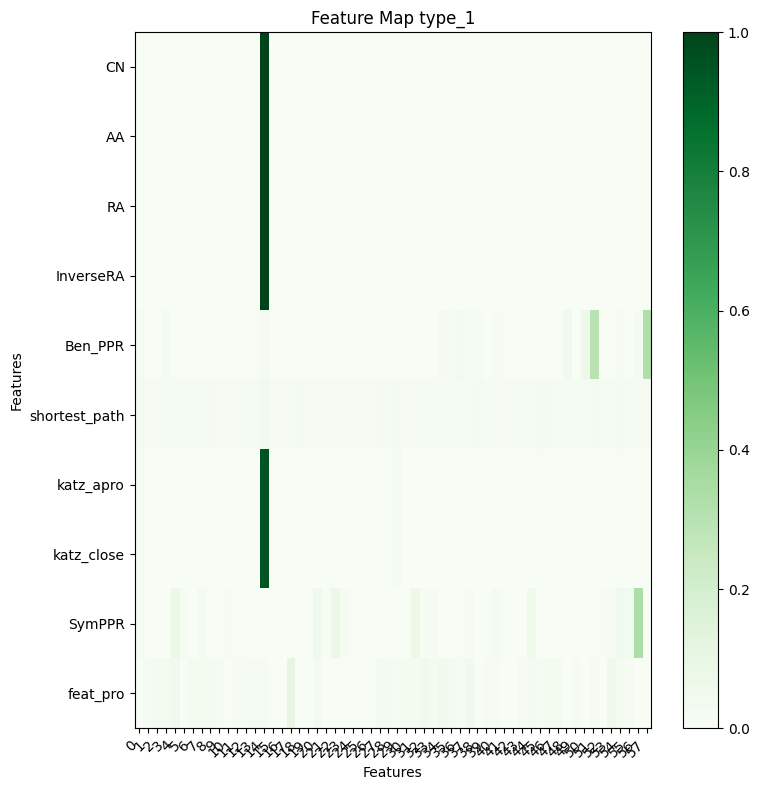

In [38]:
import numpy as np 

norm_feat_pos = eval_mix_heuristic(data, type_1)
feature_names = ['CN', 'AA', 'RA', 'InverseRA', 'Ben_PPR', 'shortest_path', 'katz_apro', 'katz_close', 'SymPPR', 'feat_pro']
index_names = [str(i) for i in range(type_1.shape[0])]
plt.figure(figsize=(8, 8))
plt.imshow(norm_feat_pos, cmap='Greens', aspect='auto')
plt.colorbar()
plt.xticks(ticks=np.arange(len(index_names)), labels=index_names, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Feature Map type_1')
plt.tight_layout()

100%|██████████| 1/1 [00:00<00:00, 357.51it/s]


evaluated Common Neighbours for 20 edges


100%|██████████| 1/1 [00:00<00:00, 343.09it/s]


evaluated Adamic Adar for 20 edges


100%|██████████| 1/1 [00:00<00:00, 353.56it/s]


evaluated Resource Allocation for 20 edges


100%|██████████| 1/1 [00:00<00:00, 349.23it/s]


evaluated InverseRA for 20 edges


100%|██████████| 20/20 [00:00<00:00, 176.04it/s]


evaluated PPR for 20 edges
remove:  False


100%|██████████| 20/20 [00:00<00:00, 36345.79it/s]


evaluated shortest path for 20 edges
remove:  False


100%|██████████| 20/20 [00:00<00:00, 3703.58it/s]


evaluated katz apro for 20 edges


100%|██████████| 20/20 [00:00<00:00, 23974.30it/s]


evaluated katz close for 20 edges


100%|██████████| 40/40 [00:00<00:00, 241.72it/s]


evaluated SymPPR for 20 edges


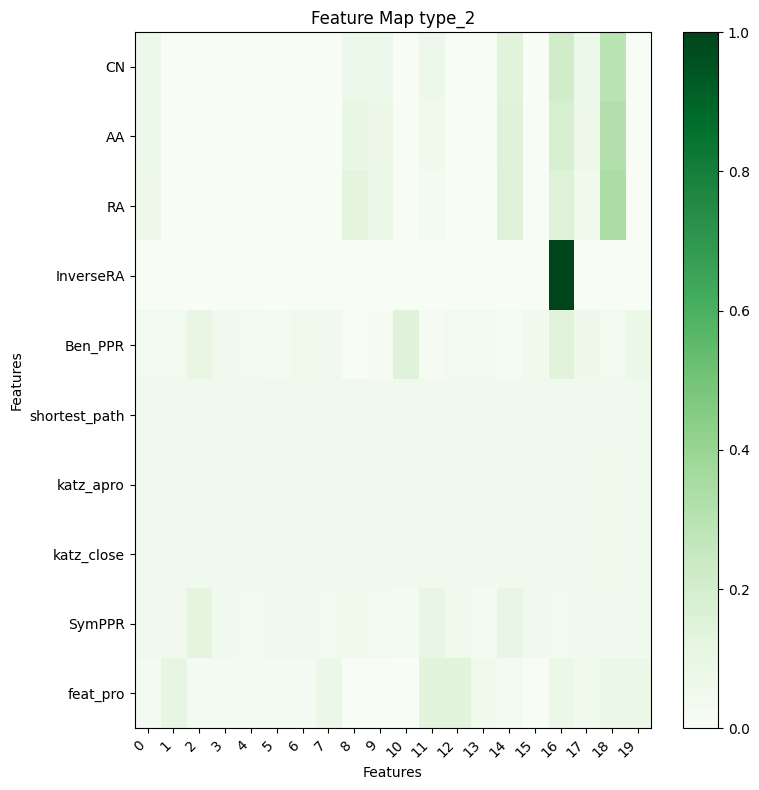

In [40]:
norm_feat_pos = eval_mix_heuristic(data, type_2)
feature_names = ['CN', 'AA', 'RA', 'InverseRA', 'Ben_PPR', 'shortest_path', 'katz_apro', 'katz_close', 'SymPPR', 'feat_pro']
index_names = [str(i) for i in range(type_2.shape[0])]
plt.figure(figsize=(8, 8))
plt.imshow(norm_feat_pos, cmap='Greens', aspect='auto')
plt.colorbar()
plt.xticks(ticks=np.arange(len(index_names)), labels=index_names, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Feature Map type_2')
plt.tight_layout()

## Duplicate

1696 Source: Title: Where Do SE-trees Perform? (Part I)
Abstract: As a classifier, a Set Enumeration (SE) tree can be viewed as a generalization of decision trees. We empirically characterize domains in which SE-trees are particularly advantageous relative to decision trees. Specifically, we show that:
2046 Target: Title: Where Do SE-trees Perform? (Part I)
Abstract: As a classifier, a Set Enumeration (SE) tree can be viewed as a generalization of decision trees. We empirically characterize domains in which SE-trees are particularly advantageous relative to decision trees. Specifically, we show that:
Duplicate 1696 Source: Title: Where Do SE-trees Perform? (Part I)
Abstract: As a classifier, a Set Enumeration (SE) tree can be viewed as a generalization of decision trees. We empirically characterize domains in which SE-trees are particularly advantageous relative to decision trees. Specifically, we show that:
2046 Target: Title: Where Do SE-trees Perform? (Part I)
Abstract: As a classifier, a Set Enumeration (SE) tree can be viewed as a generalization of decision trees. We empirically characterize domains in which SE-trees are particularly advantageous relative to decision trees. Specifically, we show that:

## What to do?